<a href="https://colab.research.google.com/github/matteo9910/interpretable-credit-risk-ml/blob/main/Creditworthness.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import math
from scipy.stats import mannwhitneyu
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTE
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree

DATASET EXPLORATION

In [ ]:
df = pd.read_csv("credit_scoring.csv")
df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,TARGET
0,5008804,M,Y,Y,0,424380.57,Working,Higher education,Civil marriage,Rented apartment,-11778.0,-4438.0,1.0,1.0,0.0,0.0,NaN,2.0,0
1,5008805,M,Y,Y,0,421593.52,Working,Higher education,Civil marriage,Rented apartment,-11777.0,-4459.0,1.0,1.0,0.0,0.0,NaN,2.0,0
2,5008806,M,Y,Y,0,110958.51,Working,Secondary / secondary special,Married,House / apartment,-21471.0,-1144.0,1.0,0.0,0.0,0.0,Security staff,2.0,0
3,5008808,F,N,Y,0,267497.96,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-18489.0,-3122.0,1.0,0.0,1.0,1.0,Sales staff,1.0,1
4,5008809,F,N,Y,0,263419.09,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19093.0,-3070.0,1.0,0.0,1.0,1.0,Sales staff,1.0,1


In [ ]:
df.shape

(338427, 19)

Note: The ID column was dropped as it contains only unique identifiers for each observation and does not contribute to the prediction task.

In [ ]:
df = df.drop("ID", axis = 1)
df.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,TARGET
0,M,Y,Y,0,424380.57,Working,Higher education,Civil marriage,Rented apartment,-11778.0,-4438.0,1.0,1.0,0.0,0.0,NaN,2.0,0
1,M,Y,Y,0,421593.52,Working,Higher education,Civil marriage,Rented apartment,-11777.0,-4459.0,1.0,1.0,0.0,0.0,NaN,2.0,0
2,M,Y,Y,0,110958.51,Working,Secondary / secondary special,Married,House / apartment,-21471.0,-1144.0,1.0,0.0,0.0,0.0,Security staff,2.0,0
3,F,N,Y,0,267497.96,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-18489.0,-3122.0,1.0,0.0,1.0,1.0,Sales staff,1.0,1
4,F,N,Y,0,263419.09,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19093.0,-3070.0,1.0,0.0,1.0,1.0,Sales staff,1.0,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338427 entries, 0 to 338426
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   CODE_GENDER          338427 non-null  object 
 1   FLAG_OWN_CAR         338427 non-null  object 
 2   FLAG_OWN_REALTY      338427 non-null  object 
 3   CNT_CHILDREN         338427 non-null  int64  
 4   AMT_INCOME_TOTAL     338427 non-null  float64
 5   NAME_INCOME_TYPE     338427 non-null  object 
 6   NAME_EDUCATION_TYPE  338427 non-null  object 
 7   NAME_FAMILY_STATUS   338426 non-null  object 
 8   NAME_HOUSING_TYPE    338426 non-null  object 
 9   DAYS_BIRTH           338426 non-null  float64
 10  DAYS_EMPLOYED        338426 non-null  float64
 11  FLAG_MOBIL           338426 non-null  float64
 12  FLAG_WORK_PHONE      338426 non-null  float64
 13  FLAG_PHONE           338426 non-null  float64
 14  FLAG_EMAIL           338426 non-null  float64
 15  OCCUPATION_TYPE  

In [ ]:
df.describe()

,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,TARGET
count,338427.000000,3.384270e+05,338426.000000,338426.000000,338426.0,338426.000000,338426.000000,338426.000000,338426.000000,338427.000000
mean,0.428934,1.876685e+05,-15998.212897,60234.533869,1.0,0.211379,0.293302,0.105181,2.197228,0.087824
std,0.727990,1.107863e+05,4193.088539,138522.923248,0.0,0.408287,0.455276,0.306787,0.899570,0.283039
min,0.000000,2.554898e+04,-26636.000000,-17973.000000,1.0,0.000000,0.000000,0.000000,1.000000,0.000000
25%,0.000000,1.212299e+05,-19467.000000,-3116.000000,1.0,0.000000,0.000000,0.000000,2.000000,0.000000
50%,0.000000,1.628553e+05,-15623.000000,-1483.000000,1.0,0.000000,0.000000,0.000000,2.000000,0.000000
75%,1.000000,2.252082e+05,-12516.250000,-378.000000,1.0,0.000000,1.000000,0.000000,3.000000,0.000000
max,19.000000,7.071016e+06,-7566.000000,396498.000000,1.0,1.000000,1.000000,1.000000,20.000000,1.000000


CLASS DISTRIBUTION ANALYSIS

In [ ]:
target_count = df["TARGET"].value_counts()
target_count

,count
TARGET,
0,308705
1,29722


In [ ]:
print(f"Customer with Low Creditworthiness: {target_count[0]/target_count.sum()*100:.2f}%")
print(f"Customer with High Creditworthiness: {target_count[1]/target_count.sum()*100:.2f}%")

Customer with Low Creditworthiness: 91.22%
Customer with High Creditworthiness: 8.78%


The dataset shows a significant class imbalance: approximately 91.22% of customers have low creditworthiness, while only 8.78% are considered highly creditworthy. This imbalance is a critical aspect to consider when training classification models, as it may lead to biased predictions favoring the majority class. Proper strategies such as class weighting, oversampling, or undersampling will be explored to address this issue.

CATEGORICAL FEATURE ANALYSIS

In this section, we explore the categorical variables present in the dataset. For each categorical feature, we examine the unique categories and their absolute frequencies. This helps to better understand the nature and distribution of these features, and will inform the appropriate preprocessing strategies such as encoding or grouping of low-frequency categories.

In [ ]:
def check_categorical_columns(df):
  for col in df.select_dtypes(include=['object']).columns:
    print(df[col].value_counts())
    print("-"*40)

In [ ]:
check_categorical_columns(df)

CODE_GENDER
F    227916
M    110511
Name: count, dtype: int64
----------------------------------------
FLAG_OWN_CAR
N    213196
Y    125231
Name: count, dtype: int64
----------------------------------------
FLAG_OWN_REALTY
Y    231307
N    107120
Name: count, dtype: int64
----------------------------------------
NAME_INCOME_TYPE
Working                 174366
Commercial associate     78090
Pensioner                57841
State servant            28113
Student                     17
Name: count, dtype: int64
----------------------------------------
NAME_EDUCATION_TYPE
Secondary / secondary special    232568
Higher education                  91062
Incomplete higher                 11387
Lower secondary                    3177
Academic degree                     232
Secondary / se                        1
Name: count, dtype: int64
----------------------------------------
NAME_FAMILY_STATUS
Married                 231494
Single / not married     42509
Civil marriage           28516
Separate

HANDLING MISSING VALUES

In [ ]:
df.isna().sum()

,0
CODE_GENDER,0
FLAG_OWN_CAR,0
FLAG_OWN_REALTY,0
CNT_CHILDREN,0
AMT_INCOME_TOTAL,0
NAME_INCOME_TYPE,0
NAME_EDUCATION_TYPE,0
NAME_FAMILY_STATUS,1
NAME_HOUSING_TYPE,1
DAYS_BIRTH,1


We observe that many missing values are concentrated in the OCCUPATION_TYPE column. Initially, we hypothesize that missing occupation values may belong to pensioners. We confirm this by checking that all individuals labeled as 'Pensioner' in the NAME_INCOME_TYPE column have missing occupation information

In [ ]:
pensioner_occupation = df[df["NAME_INCOME_TYPE"]=="Pensioner"]["OCCUPATION_TYPE"]
pensioner_occupation.isnull().sum()

np.int64(57841)

To refine our imputation strategy, we inspect the remaining missing values in OCCUPATION_TYPE for individuals whose income type is not 'Pensioner'. This allows us to tailor the imputation more precisely by income category.

In [ ]:
occupation_null_other_income = df[(df["OCCUPATION_TYPE"].isna()) & (df["NAME_INCOME_TYPE"] != "Pensioner")]
occupation_null_other_income["NAME_INCOME_TYPE"].value_counts()

,count
NAME_INCOME_TYPE,
Working,27784
Commercial associate,12927
State servant,4785
Student,5


In [ ]:
df["OCCUPATION_TYPE"].mode()[0]

'Laborers'

We calculate the mode of OCCUPATION_TYPE for each income category in NAME_INCOME_TYPE. This allows us to impute missing occupation values based on the most typical occupation for each income group.



In [ ]:
occupation_mode_by_income = df.groupby("NAME_INCOME_TYPE")["OCCUPATION_TYPE"].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
occupation_mode_by_income

,OCCUPATION_TYPE
NAME_INCOME_TYPE,
Commercial associate,Laborers
Pensioner,None
State servant,Core staff
Student,Core staff
Working,Laborers


We impute the missing OCCUPATION_TYPE values using a two-step strategy. First, we assign 'Pension' to pensioners. Then, for remaining missing values, we impute based on the most common occupation within each income group using the previously computed modes.

In [ ]:
df.loc[df["NAME_INCOME_TYPE"] == "Pensioner", "OCCUPATION_TYPE"] = "Pension"

for income_type, occupation_mode in occupation_mode_by_income.items():
    df.loc[(df["OCCUPATION_TYPE"].isna()) & (df["NAME_INCOME_TYPE"] == income_type), "OCCUPATION_TYPE"] = occupation_mode

In [ ]:
df.isna().sum()

,0
CODE_GENDER,0
FLAG_OWN_CAR,0
FLAG_OWN_REALTY,0
CNT_CHILDREN,0
AMT_INCOME_TOTAL,0
NAME_INCOME_TYPE,0
NAME_EDUCATION_TYPE,0
NAME_FAMILY_STATUS,1
NAME_HOUSING_TYPE,1
DAYS_BIRTH,1


Finally, we impute the few remaining missing values in numerical columns using the median and in categorical columns using the mode. This ensures no missing values remain in the dataset and maintains statistical consistency.

In [ ]:
numerical_col = ["CNT_FAM_MEMBERS", "DAYS_EMPLOYED", "DAYS_BIRTH"]
replace_with = df[numerical_col].median()
df[numerical_col] = df[numerical_col].fillna(replace_with)
df[numerical_col].isna().sum()

,0
CNT_FAM_MEMBERS,0
DAYS_EMPLOYED,0
DAYS_BIRTH,0


In [ ]:
categorical_col = ["NAME_FAMILY_STATUS", "NAME_HOUSING_TYPE", "FLAG_MOBIL", "FLAG_WORK_PHONE", "FLAG_PHONE", "FLAG_EMAIL"]
replace_with = df[categorical_col].mode().iloc[0]
df[categorical_col] = df[categorical_col].fillna(replace_with)
df[categorical_col].isna().sum()

,0
NAME_FAMILY_STATUS,0
NAME_HOUSING_TYPE,0
FLAG_MOBIL,0
FLAG_WORK_PHONE,0
FLAG_PHONE,0
FLAG_EMAIL,0


DUPLICATE RECORDS CHECK

In [ ]:
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates} Percentage of dataset: {duplicates/df.shape[0]*100:.2f}%")

Number of duplicate rows: 0 Percentage of dataset: 0.00%


GRAPHICAL ANALYSIS

In [ ]:
numerical_col = ["AMT_INCOME_TOTAL", "DAYS_BIRTH", "DAYS_EMPLOYED"]
categorical_col = ["CODE_GENDER", "FLAG_OWN_CAR", "FLAG_OWN_REALTY", "NAME_INCOME_TYPE", "NAME_EDUCATION_TYPE", "NAME_FAMILY_STATUS", "NAME_HOUSING_TYPE", "FLAG_MOBIL", "FLAG_WORK_PHONE", "FLAG_PHONE", "OCCUPATION_TYPE", "CNT_FAM_MEMBERS", "CNT_CHILDREN"]

In [ ]:
def plot_numerical_features(df, numerical_cols):
    for col in numerical_cols:
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))

        # Calcolo delle metriche statistiche
        mean = df[col].mean()
        median = df[col].median()
        std_dev = df[col].std()
        iqr = df[col].quantile(0.75) - df[col].quantile(0.25)
        skewness = stats.skew(df[col].dropna())
        kurt = stats.kurtosis(df[col].dropna())

        # Istogramma con curva di densità
        sns.histplot(df[col], bins=50, kde=True, ax=axes[0], color='steelblue')
        axes[0].set_title(f"Distribuzione di {col}")
        axes[0].set_ylabel("Densità")

        # Boxplot
        sns.boxplot(y=df[col], ax=axes[1], color='steelblue')
        axes[1].set_title(f"Boxplot di {col}")

        # QQ-Plot per verificare normalità
        stats.probplot(df[col].dropna(), dist="norm", plot=axes[2])
        axes[2].set_title(f"QQ-plot di {col}")

        # Inseriamo il riquadro con le statistiche sulla prima figura (in alto a sinistra)
        stat_text = (
            f"Media: {mean:.2f}\n"
            f"Mediana: {median:.2f}\n"
            f"Dev. Std: {std_dev:.2f}\n"
            f"IQR: {iqr:.2f}\n"
            f"Asimmetria (Skewness): {skewness:.2f}\n"
            f"Curtosi (Kurtosis): {kurt:.2f}"
        )

        # Posizioniamo il testo in alto a sinistra
        axes[0].text(
            0.02, 0.98, stat_text, transform=axes[0].transAxes,
            fontsize=10, verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="lightgrey")
        )

        plt.tight_layout()
        plt.show()

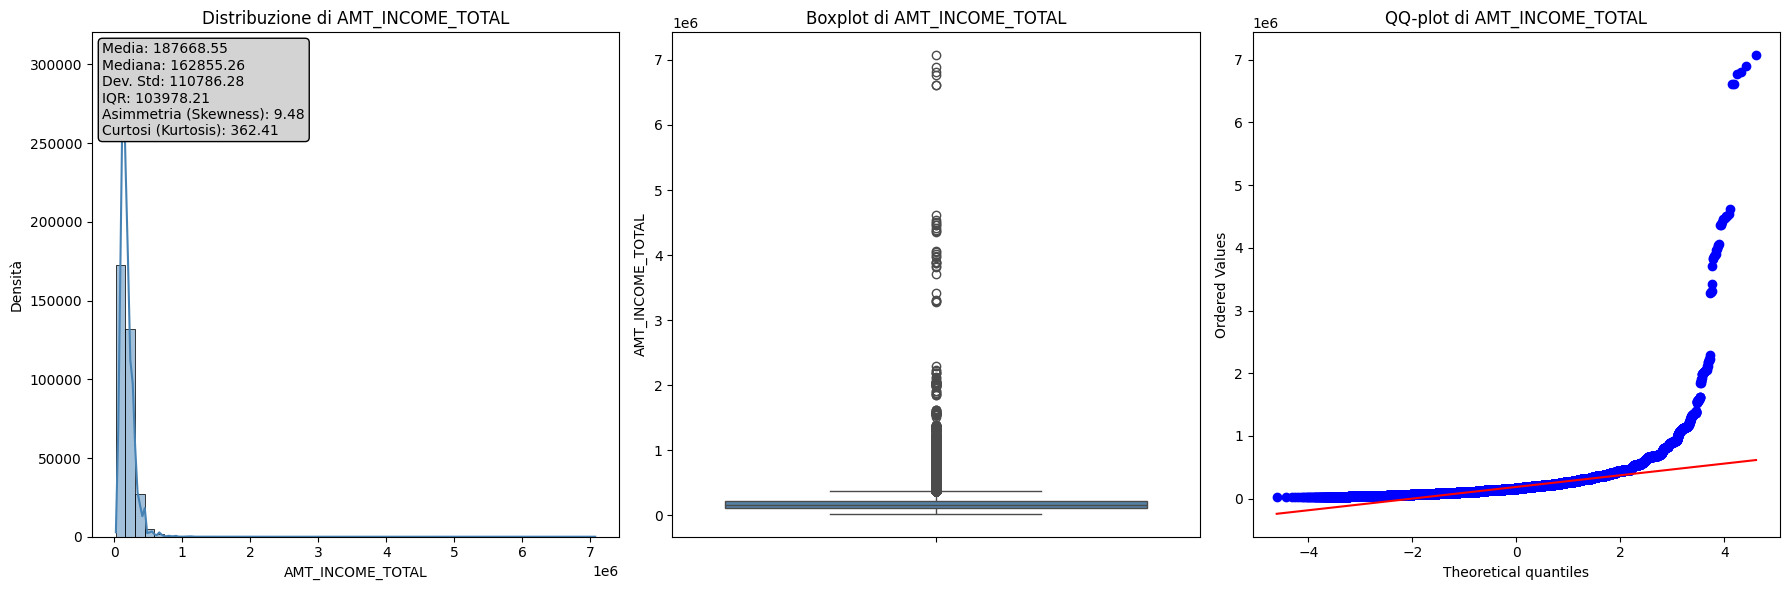

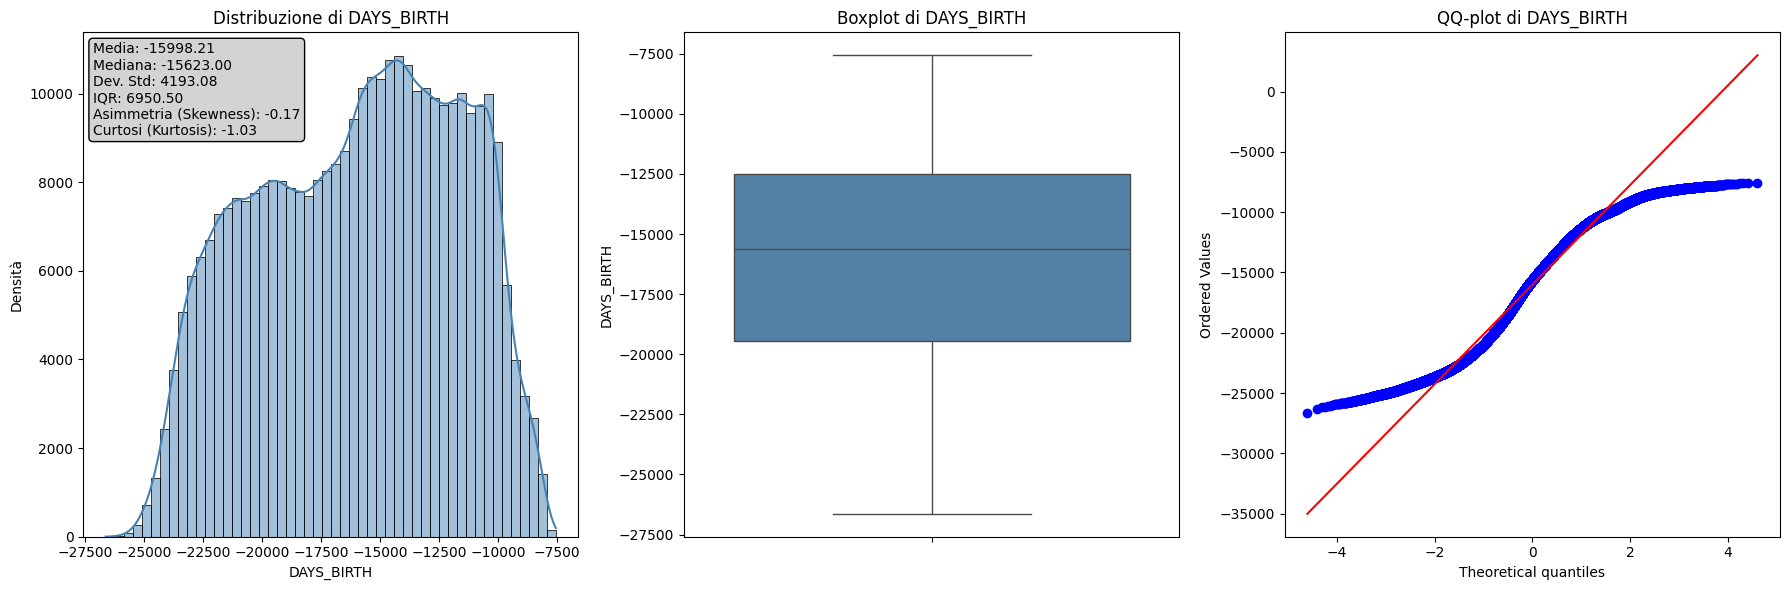

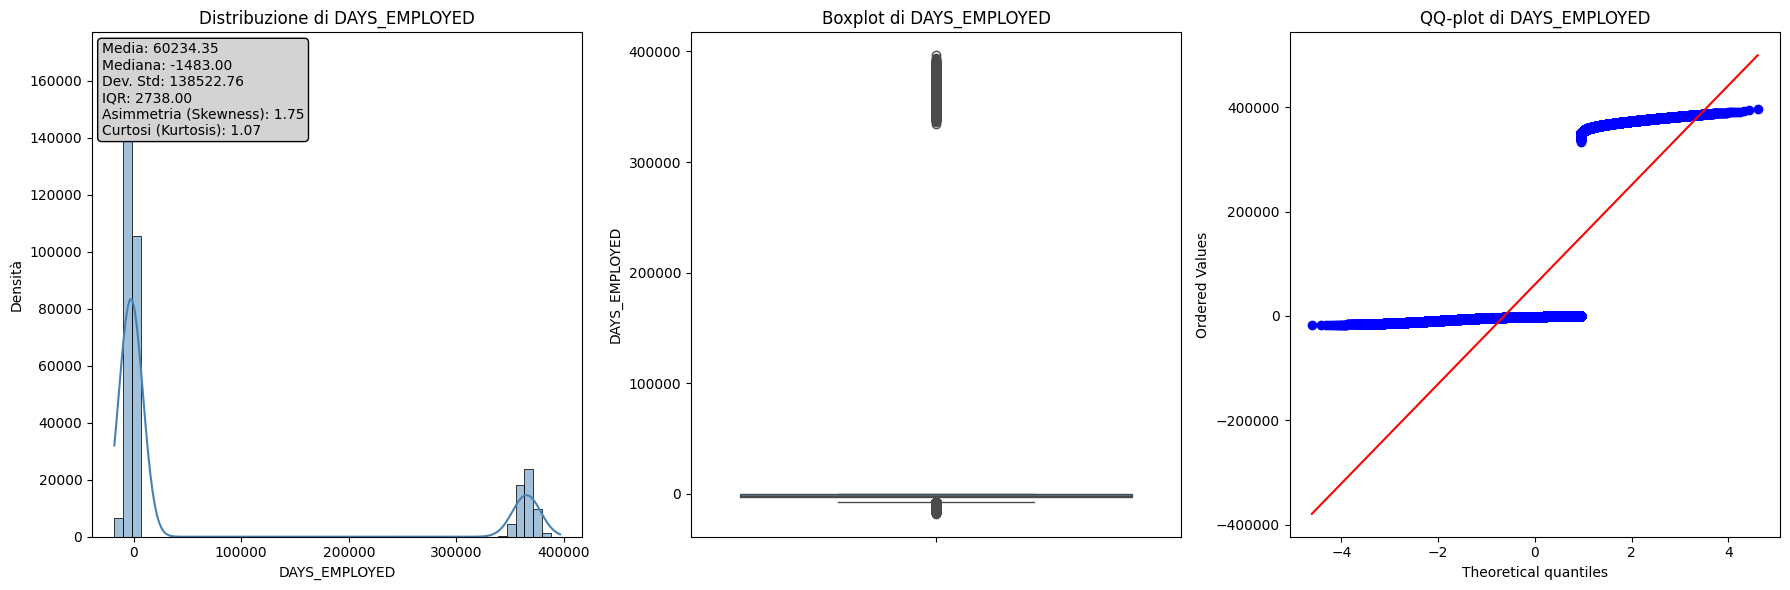

In [ ]:
plot_numerical_features(df, numerical_col)

AMT_INCOME_TOTAL
The income distribution is heavily right-skewed, as clearly shown by the histogram and a skewness value of 9.48. The boxplot reveals the presence of extreme outliers, while the QQ-plot deviates strongly from the diagonal, confirming a non-normal distribution. The mean income (≈ 187k) is significantly higher than the median (≈ 163k), which is another indicator of skewness. A kurtosis value above 300 suggests a distribution with heavy tails and high peaks.

DAYS_BIRTH
The distribution of age (represented in negative days) appears approximately symmetric, with a slight left skew (skewness = -0.17) and a moderate negative kurtosis (-1.03), suggesting a platykurtic distribution (flatter than normal). The mean and median are close, and the QQ-plot is quite aligned with the diagonal, indicating that the variable is almost normally distributed.

DAYS_EMPLOYED
This variable exhibits significant right skewness (1.75) and presents an unusual peak in the QQ-plot and boxplot, due to a cluster of values around 365,243, which likely represents anomalous or encoded values (e.g., non-working individuals or retirees). The median is around -1483 days, while the mean is inflated due to the anomaly. This variable may require further preprocessing or treatment before being used in modeling.

OUTLIER ANALYSIS OF AMT_INCOME_TOTAL

In [ ]:
outlier_threshold = 3e6
outliers_count = df[df["AMT_INCOME_TOTAL"]>outlier_threshold].shape[0]
total_count = df.shape[0]
percentage_outliers = (outliers_count/total_count)*100
outliers_df = df[df["AMT_INCOME_TOTAL"] > outlier_threshold]

print(f"Percentuale di outlier AMT_INCOME_TOTAL rispetto al totale: {percentage_outliers:.2f}%")

# Visualizziamo il dataframe degli outlier
outliers_df

Percentuale di outlier AMT_INCOME_TOTAL rispetto al totale: 0.01%


,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,TARGET
53347,M,Y,N,0,3894282.20,Commercial associate,Higher education,Civil marriage,House / apartment,-17811.0,-1105.0,1.0,0.0,0.0,1.0,Managers,2.0,0
53348,M,Y,N,0,3872490.80,Commercial associate,Higher education,Civil marriage,House / apartment,-18296.0,-1105.0,1.0,0.0,0.0,1.0,Managers,2.0,0
53349,M,Y,N,0,3817820.70,Commercial associate,Higher education,Civil marriage,House / apartment,-18716.0,-1088.0,1.0,0.0,0.0,1.0,Managers,2.0,0
53350,M,Y,N,0,3988795.62,Commercial associate,Higher education,Civil marriage,House / apartment,-18817.0,-1074.0,1.0,0.0,0.0,1.0,Managers,2.0,0
53351,M,Y,N,0,3707268.64,Commercial associate,Higher education,Civil marriage,House / apartment,-18047.0,-1100.0,1.0,0.0,0.0,1.0,Managers,2.0,0
53352,M,Y,N,0,3837186.32,Commercial associate,Higher education,Civil marriage,House / apartment,-18572.0,-1075.0,1.0,0.0,0.0,1.0,Managers,2.0,0
143177,M,Y,Y,1,4022525.57,Commercial associate,Higher education,Married,With parents,-10643.0,-3170.0,1.0,1.0,1.0,0.0,Managers,3.0,0
143178,M,Y,Y,1,4049023.17,Commercial associate,Higher education,Married,With parents,-10206.0,-3053.0,1.0,1.0,1.0,0.0,Managers,3.0,0
143179,M,Y,Y,1,4057644.98,Commercial associate,Higher education,Married,With parents,-10600.0,-3155.0,1.0,1.0,1.0,0.0,Managers,3.0,0
143180,M,Y,Y,1,3885178.32,Commercial associate,Higher education,Married,With parents,-10713.0,-3135.0,1.0,1.0,1.0,0.0,Managers,3.0,0


We investigated the extreme values in the AMT_INCOME_TOTAL variable by setting an upper threshold of 3,000,000. These outliers represent only 0.01% of the total dataset, indicating a negligible impact in terms of volume. Upon closer inspection, we noticed that individuals with these high income values share several common characteristics: they typically have higher education, most of them own real estate, and many are employed as managers. Given that these traits can plausibly explain high income levels, we decided to retain the outliers in the dataset without applying any transformation or removal.

OUTLIER TREATMENT FOR DAYS_EMPLOYED

In [ ]:
outlier_threshold = 15000
outliers_count = df[df["DAYS_EMPLOYED"]>outlier_threshold].shape[0]
total_count = df.shape[0]
percentage_outliers = (outliers_count/total_count)*100
outliers_df = df[df["AMT_INCOME_TOTAL"] > outlier_threshold]

print(f"Percentuale di outlier DAYS_EMPLOYED rispetto al totale: {percentage_outliers:.2f}%")

Percentuale di outlier DAYS_EMPLOYED rispetto al totale: 17.09%


In [ ]:
# Calcoliamo la mediana della variabile DAYS_EMPLOYED
median_days_employed = df["DAYS_EMPLOYED"].median()

# Sostituiamo i valori anomali (positivi) con la mediana
df.loc[df["DAYS_EMPLOYED"] > 15000, "DAYS_EMPLOYED"] = median_days_employed

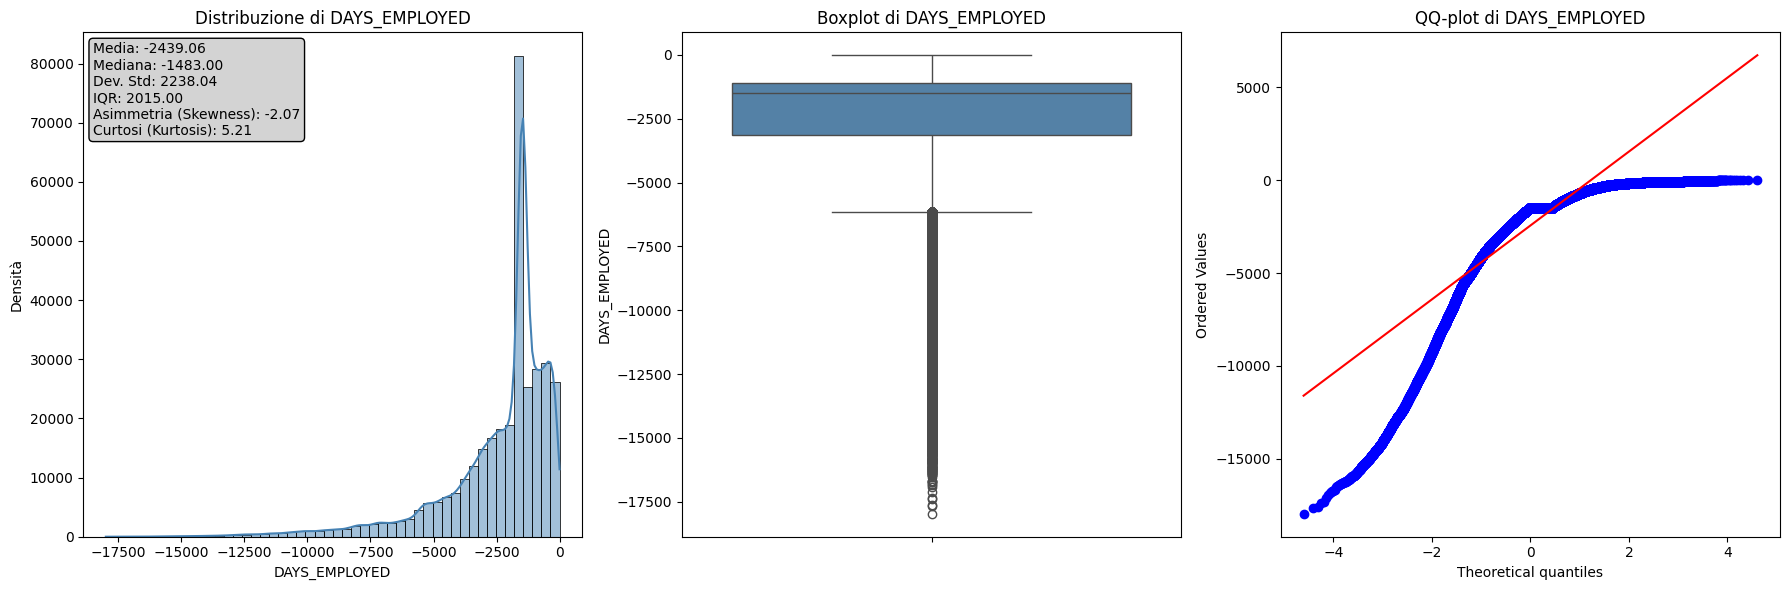

In [ ]:
plot_numerical_features(df, ["DAYS_EMPLOYED"])

In this section, we investigate the anomalous values of the DAYS_EMPLOYED variable. A threshold of 15,000 days was defined as the maximum plausible value, under the assumption that such a value might correspond to individuals who have been retired for a long time. Since values above this threshold represent a significant percentage of the total (17.09%), we opted to treat them as outliers. These anomalous values were replaced with the median of the DAYS_EMPLOYED variable to reduce distortion in the distribution. The updated distribution was then re-plotted to verify the effectiveness of the adjustment.

GRAPHICAL ANALYSIS AND DIMENSIONALITY REDUCTION OF CATEGORICAL VARIABLES

In [ ]:
def plot_categorical_features(df, categorical_cols, cols_per_row=3):
    num_plots = len(categorical_cols)
    rows = math.ceil(num_plots / cols_per_row)  # Calcola il numero di righe

    fig, axes = plt.subplots(rows, cols_per_row, figsize=(cols_per_row * 5, rows * 5))
    axes = axes.flatten()  # Appiattiamo per iterare più facilmente

    for i, col in enumerate(categorical_cols):
        value_counts = df[col].value_counts()
        relative_freq = df[col].value_counts(normalize=True) * 100  # Percentuale

        sns.barplot(
            x=value_counts.index,
            y=value_counts.values,
            hue=value_counts.index,  # Assegniamo la variabile a hue
            palette="Blues_r",  # Manteniamo la palette
            ax=axes[i],
            legend=False  # Disattiva la legenda
        )

        axes[i].set_title(f"Distribuzione di {col}")
        axes[i].set_xlabel(col)
        axes[i].set_ylabel("Frequenza Assoluta")

        # Etichette con frequenza relativa
        for j, v in enumerate(value_counts.values):
            axes[i].text(j, v + (v * 0.01), f"{relative_freq.iloc[j]:.1f}%",
                         ha='center', fontsize=10, fontweight='bold')

        axes[i].tick_params(axis='x', rotation=45)  # Ruota etichette se necessario

    # Rimuove gli assi inutilizzati
    for k in range(i + 1, len(axes)):
        fig.delaxes(axes[k])

    plt.tight_layout()  # Migliora la disposizione dei grafici
    plt.show()

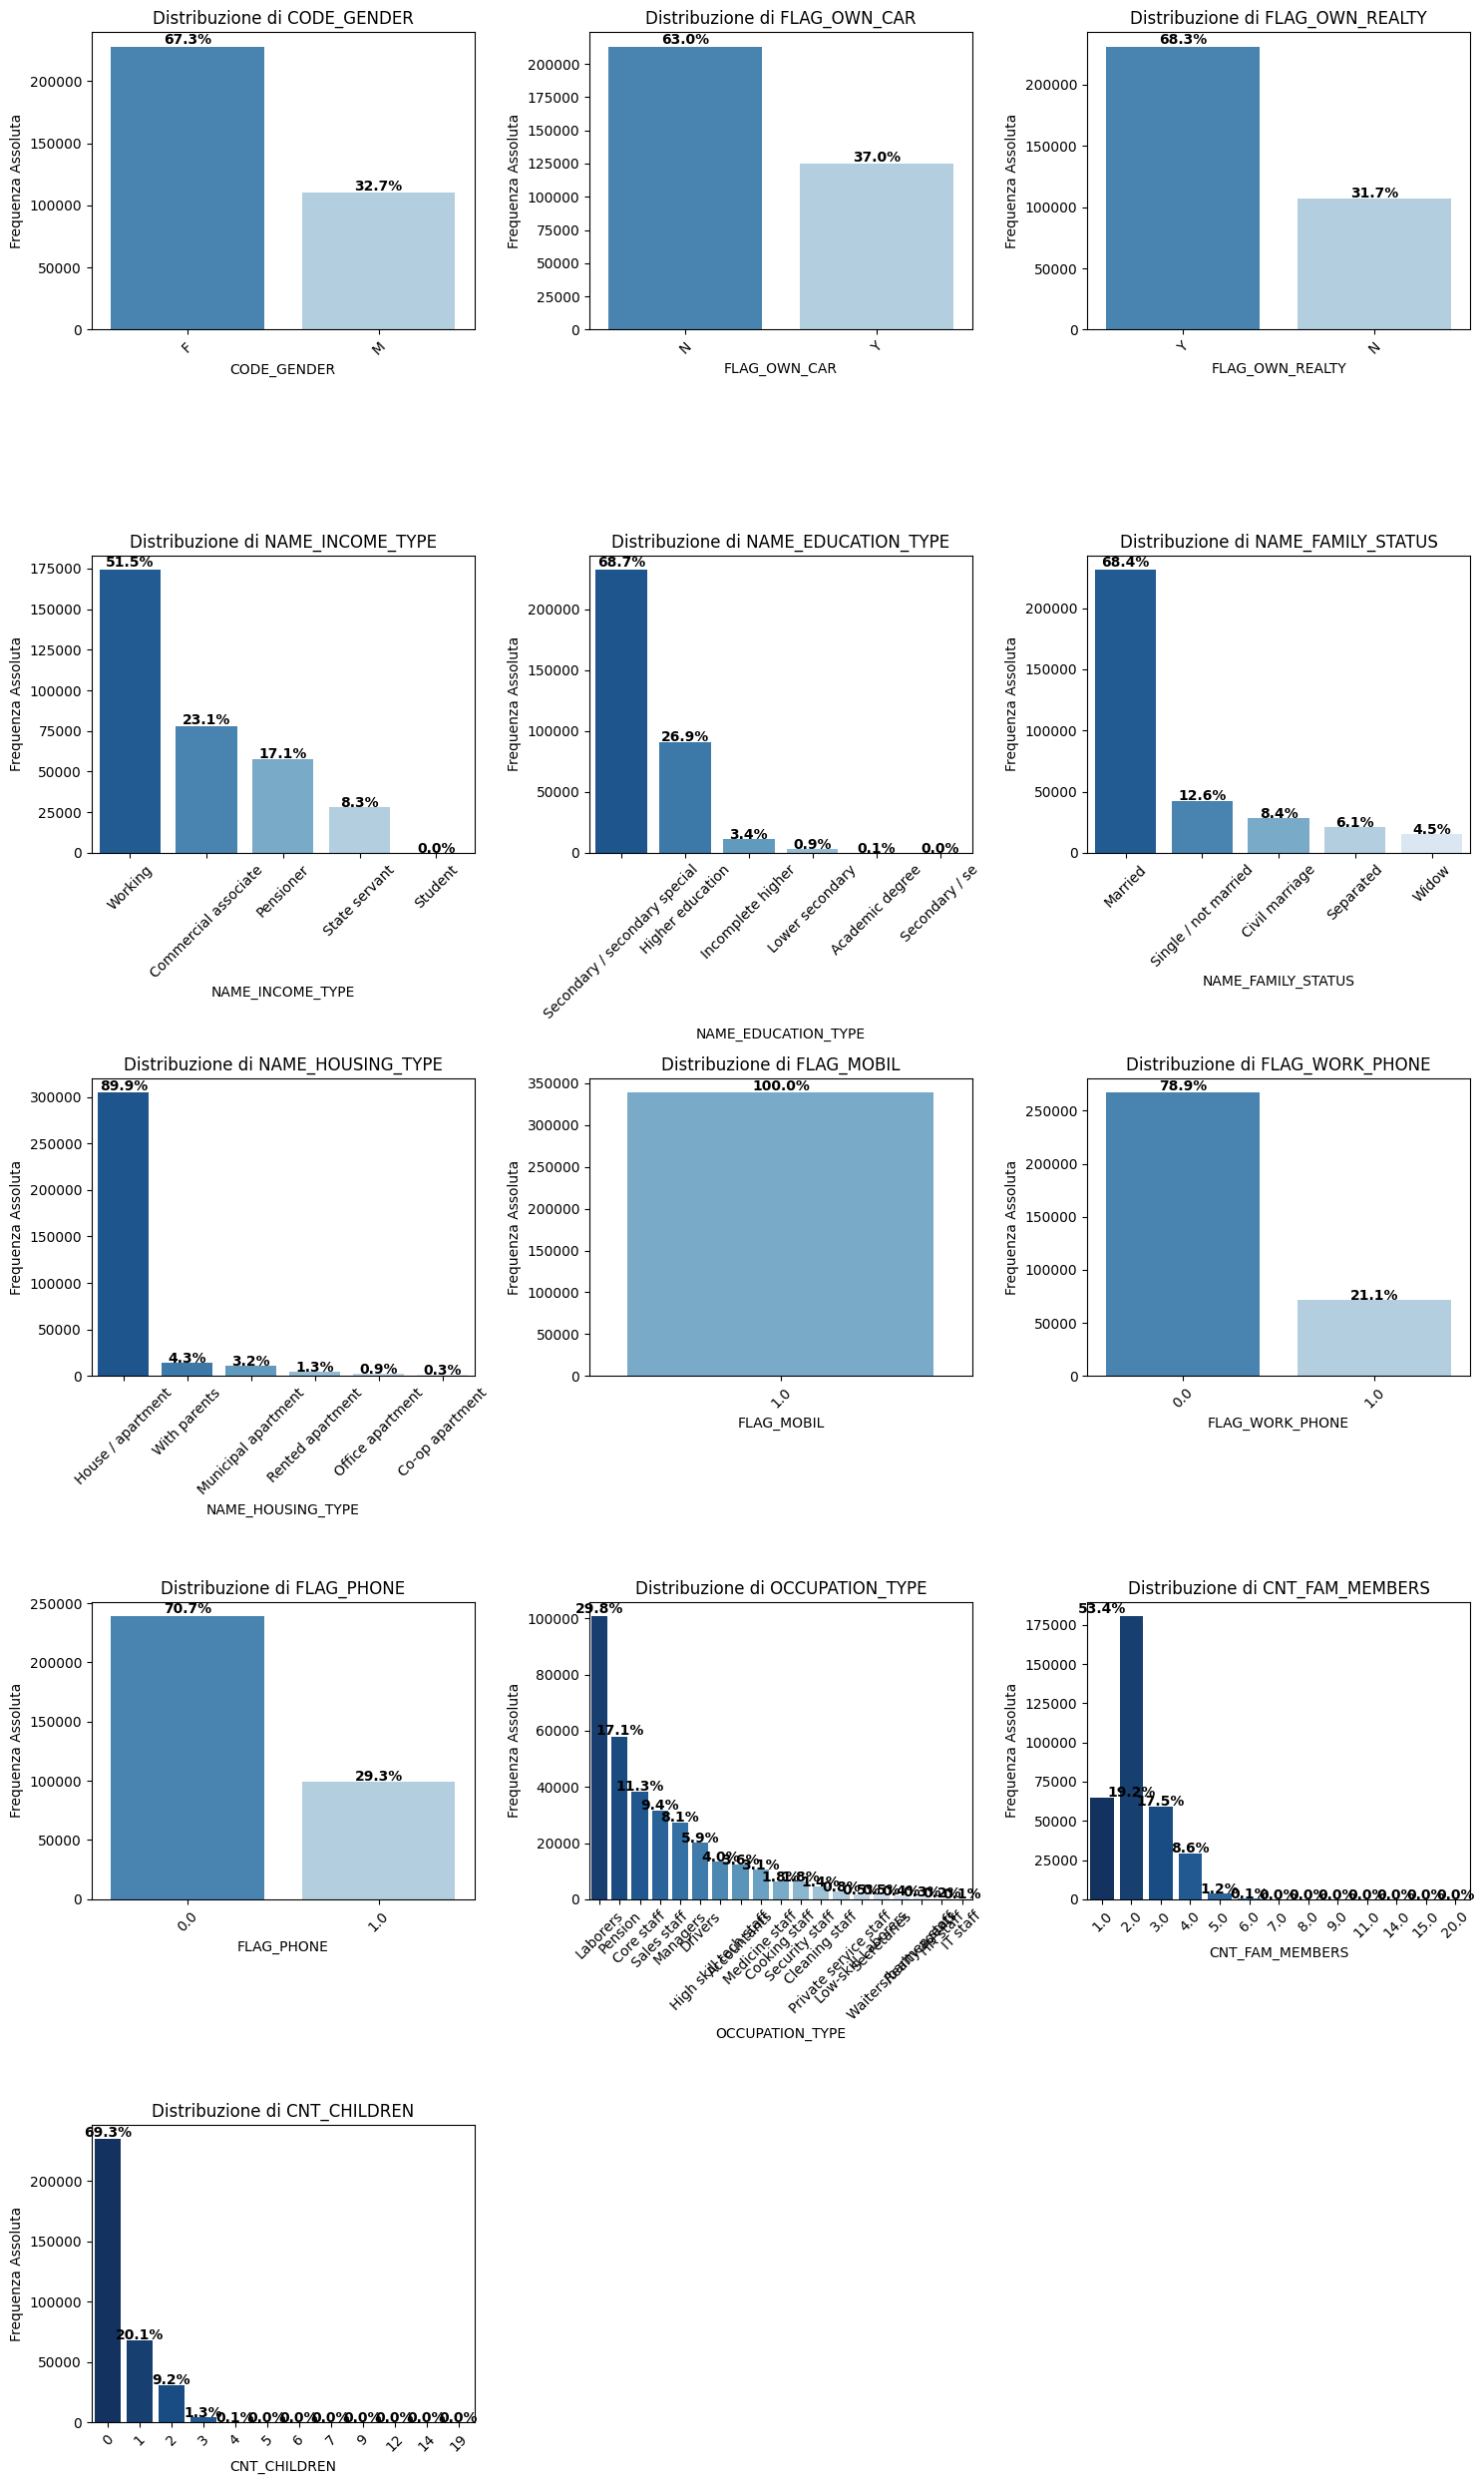

In [ ]:
plot_categorical_features(df, categorical_col)

In [ ]:
other_modality_list = ["NAME_INCOME_TYPE", "NAME_EDUCATION_TYPE", "NAME_FAMILY_STATUS", "NAME_HOUSING_TYPE", "OCCUPATION_TYPE"]

def group_rare_categories(df, categorical_features, threshold=10):
    """
    Raggruppa le modalità meno frequenti in una categoria "Other" direttamente sul DataFrame originale.

    """
    for col in categorical_features:
        value_counts = df[col].value_counts(normalize=True) * 100  # Calcola la % di frequenza per ogni modalità
        rare_categories = value_counts[value_counts < threshold].index.tolist()  # Identifica le categorie sotto la soglia

        # Usa df.loc[] per evitare il warning di "chained assignment"
        df.loc[df[col].isin(rare_categories), col] = "Other"


In [ ]:
group_rare_categories(df, other_modality_list, threshold=10)

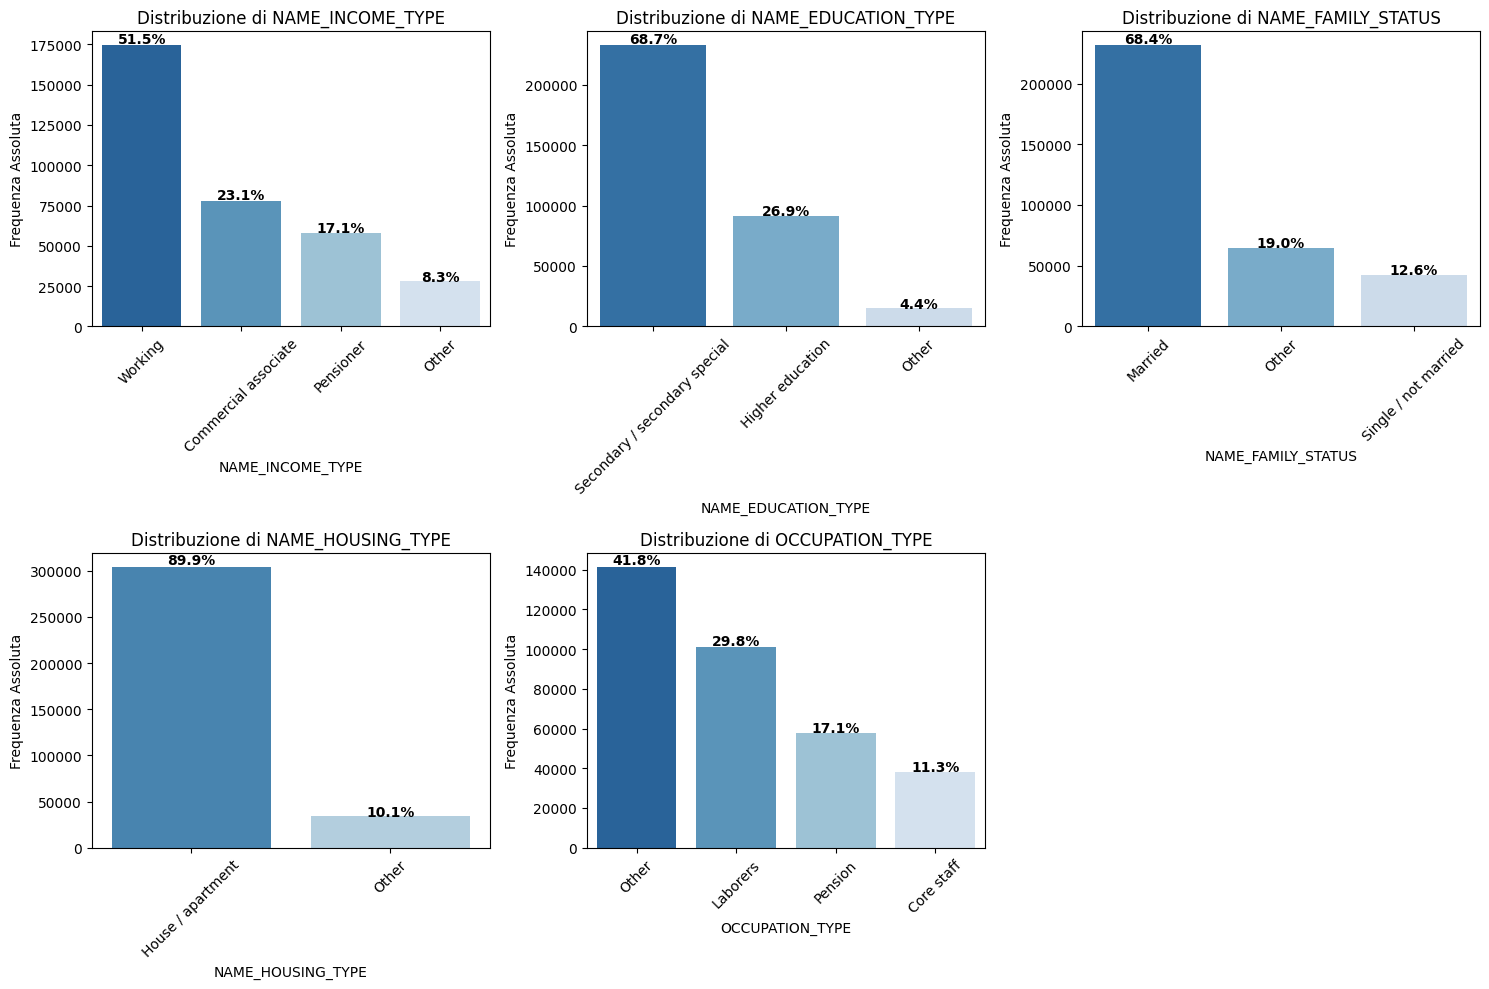

In [ ]:
plot_categorical_features(df, other_modality_list)

In this step, we performed a graphical analysis of the categorical variables. For each feature, we created bar plots where the columns represent the absolute frequency of each modality, while labels on top show the corresponding relative frequencies. To reduce dataset dimensionality in view of the upcoming One-Hot Encoding step, we grouped all categories with a relative frequency below a predefined threshold (10%) into a single category named "Other". This strategy helps to limit the number of resulting binary columns and avoids sparse representations. We then replotted the updated distributions to ensure the aggregation was applied correctly.



BINNING OF CNT_FAM_MEMBERS AND CNT_CHILDREN VARIABLES

In [ ]:
df['CNT_FAM_MEMBERS'] = df['CNT_FAM_MEMBERS'].apply(lambda x:
                                '1' if x == 1 else
                                '2' if x == 2 else
                                '3' if x == 3 else
                                '>3')

df['CNT_CHILDREN'] = df['CNT_CHILDREN'].apply(lambda x:
                                '0' if x == 0 else
                                '1' if x == 1 else
                                '2' if x == 2 else
                                '>2')

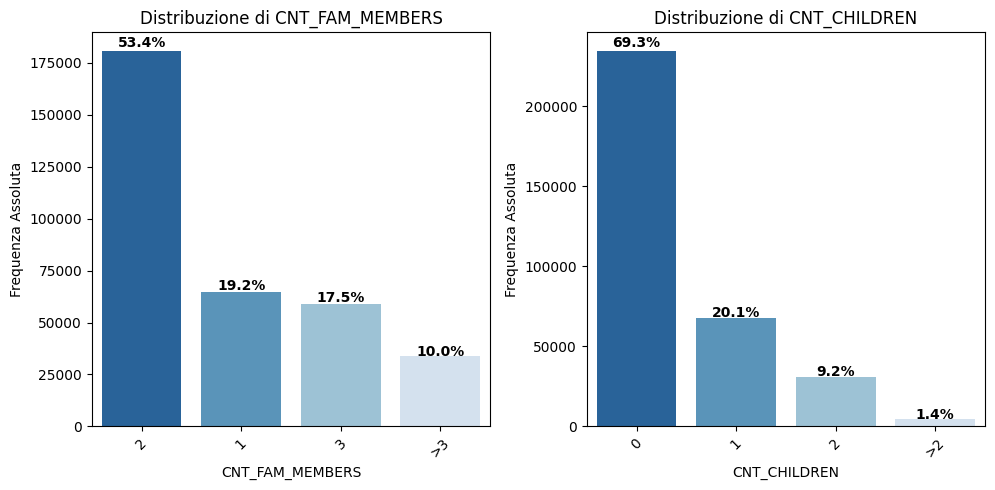

In [ ]:
plot_categorical_features(df, ["CNT_FAM_MEMBERS", "CNT_CHILDREN"])

In this section, we applied a binning strategy to the variables CNT_FAM_MEMBERS and CNT_CHILDREN. Specifically, we grouped the values into distinct classes to simplify their distribution and reduce the number of unique categories. This transformation helps make the variables more interpretable and suitable for subsequent encoding processes, especially when dealing with highly skewed or sparse counts.

REMOVAL OF NON-INFORMATIVE FEATURE FLAG_MOBIL

We decided to drop the FLAG_MOBIL feature because, as shown in the previous graphical analysis, all records shared the same value (1) for this variable. Since it does not provide any variance or discriminative information, it has no utility for further analysis or model training, and can therefore be safely removed.

In [ ]:
df = df.drop(["FLAG_MOBIL"], axis=1)

CORRELATION ANALYSIS BETWEEN CONTINUOUS VARIABLES AND TARGET


In [ ]:
def plot_box_features(df, continuous_features, target="TARGET"):

    num_features = len(continuous_features)

    # Creiamo il layout per avere i grafici affiancati
    fig, axes = plt.subplots(1, num_features, figsize=(num_features * 6, 6))

    # Se c'è solo una variabile, trasformiamo axes in una lista per iterare
    if num_features == 1:
        axes = [axes]

    for i, feature in enumerate(continuous_features):
        sns.boxplot(
            data=df,
            x=target,
            y=feature,
            hue=target,   # Assign `hue` to target
            legend=False, # Prevents Seaborn warning
            ax=axes[i],
            palette=["lightcoral", "lightblue"]
        )
        axes[i].set_title(f"Boxplot di {feature} per {target}")
        axes[i].set_xlabel(target)
        axes[i].set_ylabel(feature)

    plt.tight_layout()  # Migliora la disposizione dei grafici
    plt.show()

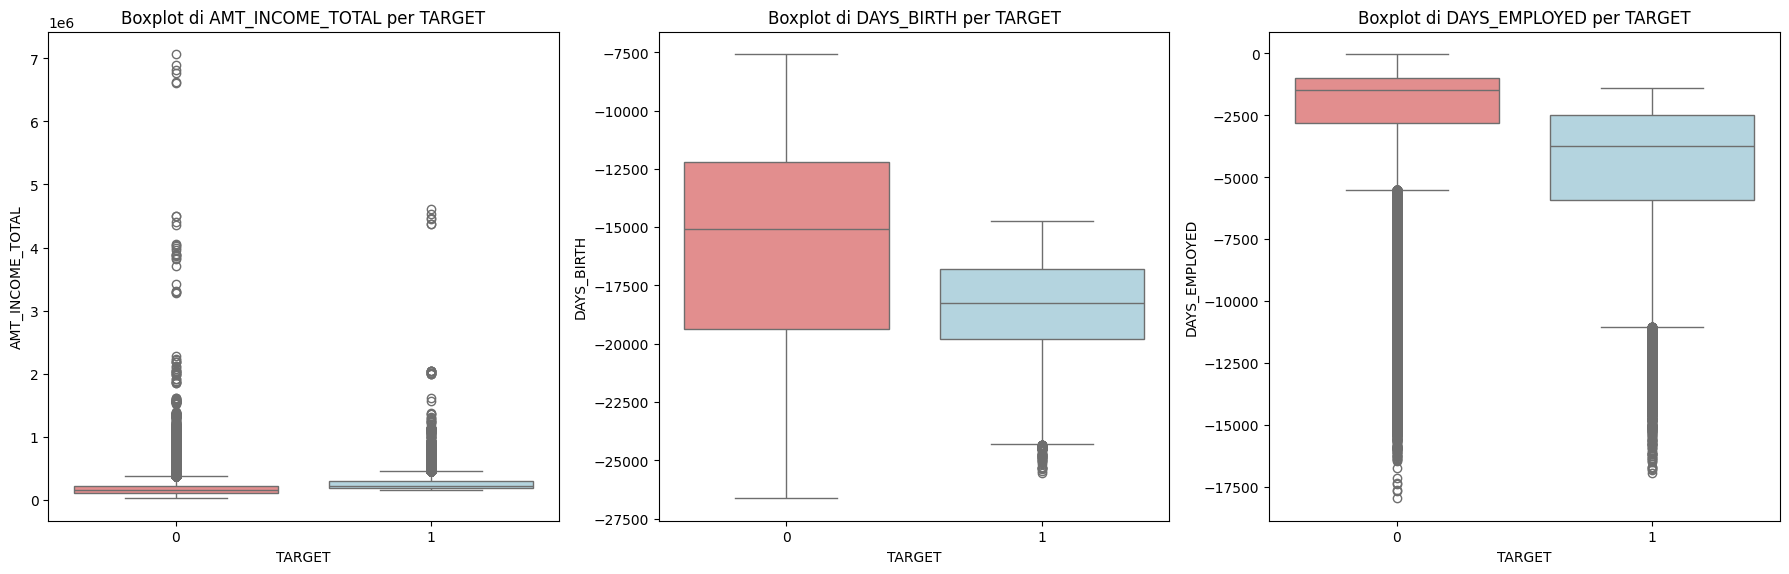

In [ ]:
plot_box_features(df, numerical_col)

In [ ]:
for feature in numerical_col:
    group0 = df[df["TARGET"] == 0][feature]
    group1 = df[df["TARGET"] == 1][feature]

    stat, p_value = mannwhitneyu(group0, group1, alternative="two-sided")
    print(f"Test Mann-Whitney per {feature}: stat={stat:.3f}, p-value={p_value:.5f}")

Test Mann-Whitney per AMT_INCOME_TOTAL: stat=1902468936.500, p-value=0.00000
Test Mann-Whitney per DAYS_BIRTH: stat=6465602862.000, p-value=0.00000
Test Mann-Whitney per DAYS_EMPLOYED: stat=7506523177.500, p-value=0.00000


In this section, we investigated the correlation between continuous variables and the target variable. We visualized the distributions of each feature using boxplots grouped by the target classes, allowing us to assess whether differences were observable between groups. To statistically validate these observations, we applied the non-parametric Mann-Whitney U test, which evaluates whether the distribution of each variable significantly differs between the two target classes. All variables reported a p-value close to 0, indicating statistically significant differences in their distributions with respect to the target.

CORRELATION MATRIX ANALYSIS OF CONTINUOUS VARIABLES

In [ ]:
def plot_correlation_matrix(df, cols):
  plt.figure(figsize=(8,6))

  hm = sns.heatmap(
      df[cols].corr(),
      annot=True,
      cbar=True,
      square=True,
      yticklabels=df[cols].columns,
      xticklabels=df[cols].columns,
      annot_kws={"size":12},
      cmap="coolwarm")

  plt.show()

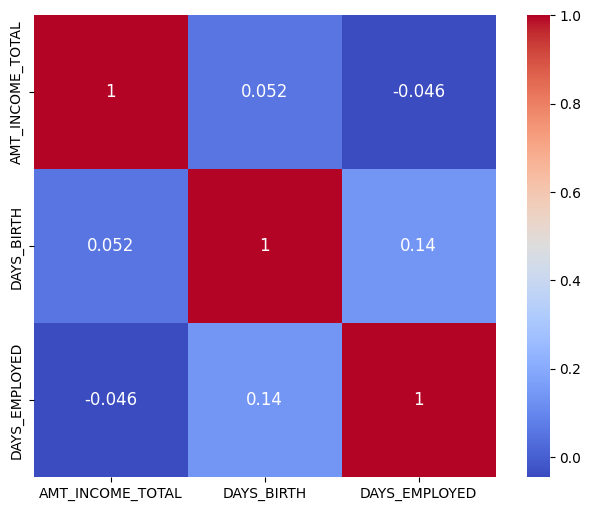

In [ ]:
plot_correlation_matrix(df, numerical_col)

In this section, we plotted the correlation matrix for the continuous variables to assess the degree of linear relationship between them. This analysis helps identify potential redundancy in the dataset due to highly correlated features. The heatmap clearly shows that the pairwise correlations between the selected continuous features are all low, indicating that each variable provides unique information. Therefore, none of the variables were removed, as they are all considered informative for subsequent modeling steps.

CORRELATION ANALYSIS BETWEEN CATEGORICAL VARIABLES AND TARGET

In [ ]:
categorical_col = ["CODE_GENDER", "FLAG_OWN_CAR", "FLAG_OWN_REALTY", "NAME_INCOME_TYPE", "NAME_EDUCATION_TYPE", "NAME_FAMILY_STATUS", "NAME_HOUSING_TYPE", "FLAG_WORK_PHONE", "FLAG_PHONE", "OCCUPATION_TYPE", "CNT_FAM_MEMBERS", "CNT_CHILDREN"]

def plot_grouped_bar_charts(df, cols, target="TARGET"):
    num_features = len(cols)
    cols_per_row = 3  # Numero massimo di grafici per riga
    rows = math.ceil(num_features / cols_per_row)  # Numero di righe necessario

    fig, axes = plt.subplots(rows, cols_per_row, figsize=(cols_per_row * 6, rows * 5))
    axes = axes.flatten()  # Rende la gestione degli assi più semplice

    for i, col in enumerate(cols):
        # Creiamo la tabella di contingenza
        contingency_table = pd.crosstab(df[col], df[target])

        # Creiamo il grafico a barre raggruppate
        contingency_table.plot(kind="bar", ax=axes[i], color=["lightcoral", "lightblue"], edgecolor="black")

        axes[i].set_title(f"Distribuzione di {col} per {target}")
        axes[i].set_xlabel(col)
        axes[i].set_ylabel("Frequenza Assoluta")
        axes[i].legend(title=target, labels=["0", "1"])  # Legenda con etichette chiare
        axes[i].tick_params(axis="x", rotation=45)  # Ruota le etichette per migliorare la leggibilità

    # Rimuoviamo eventuali assi vuoti
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

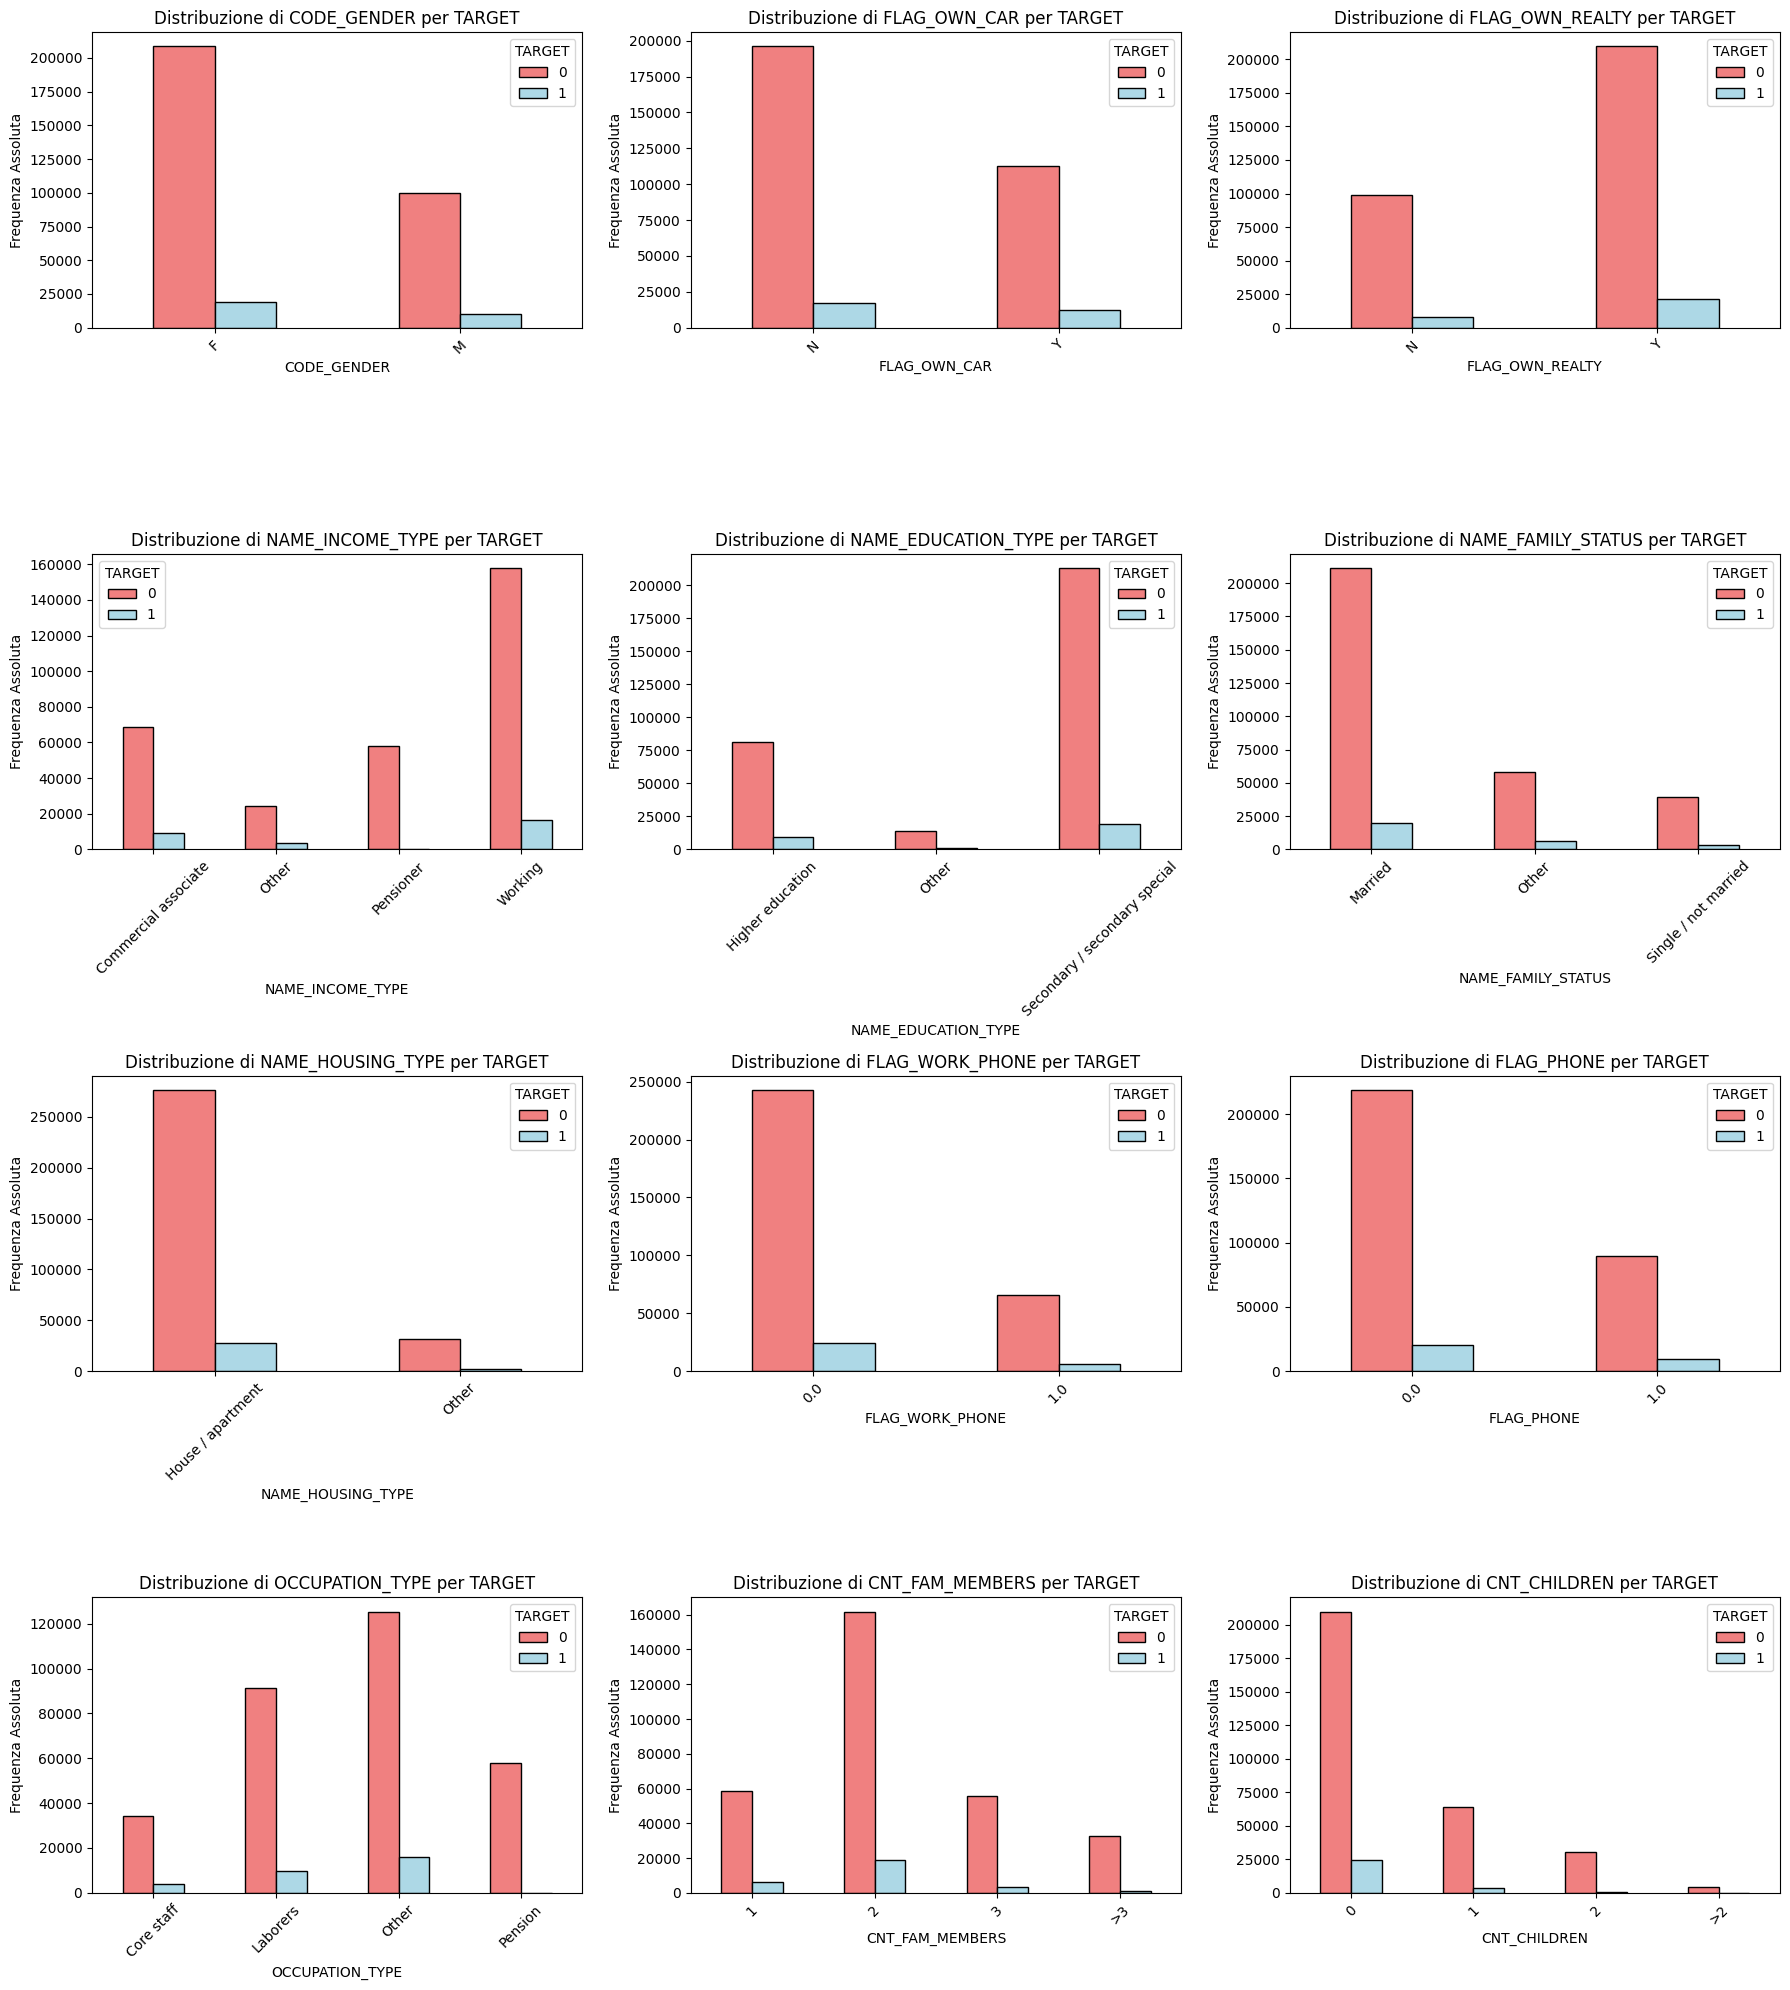

In [ ]:
plot_grouped_bar_charts(df, categorical_col)

In [ ]:
def chi_square_test(df, categorical_cols, target="TARGET"):
    results = []

    for col in categorical_cols:
        # Creiamo la tabella di contingenza
        contingency_table = pd.crosstab(df[col], df[target])

        # Applichiamo il test del Chi-Square
        chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)

        # Salviamo i risultati
        results.append({
            "Variable": col,
            "Chi-Square Statistic": chi2,
            "p-value": p_value
        })

    # Convertiamo i risultati in un DataFrame e lo ritorniamo
    results_df = pd.DataFrame(results)

    return results_df

In [ ]:
chi_square_test(df, categorical_col)

,Variable,Chi-Square Statistic,p-value
0,CODE_GENDER,74.838985,5.107121e-18
1,FLAG_OWN_CAR,401.131858,3.122801e-89
2,FLAG_OWN_REALTY,306.692313,1.147610e-68
3,NAME_INCOME_TYPE,7457.828488,0.000000e+00
4,NAME_EDUCATION_TYPE,534.863500,7.175739e-117
5,NAME_FAMILY_STATUS,196.719315,1.918419e-43
6,NAME_HOUSING_TYPE,352.035338,1.527283e-78
7,FLAG_WORK_PHONE,55.554612,9.089833e-14
8,FLAG_PHONE,81.801624,1.504548e-19
9,OCCUPATION_TYPE,6934.976394,0.000000e+00


In this section, we assessed the association between each categorical variable and the target by plotting grouped bar charts and performing a Chi-Square test.

The results show that all the analyzed categorical variables have extremely low p-values, indicating a statistically significant relationship with the target. Variables such as NAME_INCOME_TYPE, OCCUPATION_TYPE, CNT_FAM_MEMBERS, and CNT_CHILDREN demonstrate a strong association, suggesting that the target distribution differs significantly across their categories.

These findings confirm that the categorical variables analyzed are informative and potentially valuable features for predictive modeling, as they contribute to distinguishing between the two target classes.

FEATURE ENCODING OF CATEGORICAL VARIABLES

In [ ]:
label_encode_cols = ["CODE_GENDER", "FLAG_OWN_CAR", "FLAG_OWN_REALTY", "NAME_HOUSING_TYPE"]

label_encoder = LabelEncoder()

for col in label_encode_cols:
    df[col] = label_encoder.fit_transform(df[col])

df.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,TARGET
0,1,1,1,0,424380.57,Working,Higher education,Other,1,-11778.0,-4438.0,1.0,0.0,0.0,Laborers,2,0
1,1,1,1,0,421593.52,Working,Higher education,Other,1,-11777.0,-4459.0,1.0,0.0,0.0,Laborers,2,0
2,1,1,1,0,110958.51,Working,Secondary / secondary special,Married,0,-21471.0,-1144.0,0.0,0.0,0.0,Other,2,0
3,0,0,1,0,267497.96,Commercial associate,Secondary / secondary special,Single / not married,0,-18489.0,-3122.0,0.0,1.0,1.0,Other,1,1
4,0,0,1,0,263419.09,Commercial associate,Secondary / secondary special,Single / not married,0,-19093.0,-3070.0,0.0,1.0,1.0,Other,1,1


In [ ]:
ohe_cols = ["NAME_INCOME_TYPE", "NAME_EDUCATION_TYPE", "NAME_FAMILY_STATUS",
        "CNT_CHILDREN", "CNT_FAM_MEMBERS", "OCCUPATION_TYPE"]

ohe = OneHotEncoder(drop="first")
encoded = ohe.fit_transform(df[ohe_cols])
encoded_df = pd.DataFrame(encoded.toarray(), columns=ohe.get_feature_names_out(ohe_cols))
encoded_df.shape

(338427, 16)

In [ ]:
df = df.drop(columns=ohe_cols).reset_index(drop=True)
encoded_df = encoded_df.reset_index(drop=True)

df = pd.concat([df, encoded_df], axis=1)
df.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,...,NAME_FAMILY_STATUS_Single / not married,CNT_CHILDREN_1,CNT_CHILDREN_2,CNT_CHILDREN_>2,CNT_FAM_MEMBERS_2,CNT_FAM_MEMBERS_3,CNT_FAM_MEMBERS_>3,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Other,OCCUPATION_TYPE_Pension
0,1,1,1,424380.57,1,-11778.0,-4438.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,1,1,1,421593.52,1,-11777.0,-4459.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,1,1,1,110958.51,0,-21471.0,-1144.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0,0,1,267497.96,0,-18489.0,-3122.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0,0,1,263419.09,0,-19093.0,-3070.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
df.shape

(338427, 27)

In this section, we performed encoding of categorical variables to prepare the dataset for machine learning algorithms. Label Encoding was applied to nominal variables with no intrinsic ordering (e.g., CODE_GENDER, FLAG_OWN_CAR, FLAG_OWN_REALTY, NAME_HOUSING_TYPE), mapping each category to a unique integer. For the remaining categorical variables, One-Hot Encoding was used to avoid introducing artificial ordinal relationships and to retain interpretability. The first category was dropped in the one-hot encoding process to avoid multicollinearity.

DATASET SPLITTING AND NORMALIZATION

In [ ]:
RANDOM_SEED = 0
X = df.drop("TARGET", axis=1).values
y = df["TARGET"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED, stratify=y)

print(f"Dimensione X_train: {X_train.shape}")
print(f"Dimensione X_test: {X_test.shape}")
print(f"Dimensione y_train: {y_train.shape}")
print(f"Dimensione y_test: {y_test.shape}")

Dimensione X_train: (236898, 26)
Dimensione X_test: (101529, 26)
Dimensione y_train: (236898,)
Dimensione y_test: (101529,)


In [ ]:
mms = MinMaxScaler()
X_train = mms.fit_transform(X_train)
X_test = mms.transform(X_test)


MODEL APPLICATIONS

 LOGISTIC REGRESSION WITH BALANCED CLASS WEIGHTS

 We trained a Logistic Regression model using the class_weight="balanced" parameter to address the significant class imbalance in the dataset. This ensures the algorithm gives more importance to the minority class (positive creditworthiness) during training.

In [ ]:
lr = LogisticRegression(class_weight="balanced")
lr.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

In [ ]:
y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

print("TRAIN REPORT")
print(classification_report(y_train, y_pred_train))
print("TEST REPORT")
print(classification_report(y_test, y_pred_test))

TRAIN REPORT
              precision    recall  f1-score   support

           0       0.99      0.81      0.89    216093
           1       0.31      0.89      0.46     20805

    accuracy                           0.82    236898
   macro avg       0.65      0.85      0.68    236898
weighted avg       0.93      0.82      0.85    236898

TEST REPORT
              precision    recall  f1-score   support

           0       0.99      0.82      0.89     92612
           1       0.32      0.90      0.47      8917

    accuracy                           0.82    101529
   macro avg       0.65      0.86      0.68    101529
weighted avg       0.93      0.82      0.86    101529



From the classification report, we observe:

Recall for class 0 (low creditworthiness) is 0.82 on the test set, meaning the model correctly identifies 82% of clients who are actually risky.

Precision for class 1 (high creditworthiness) is 0.32, indicating that when the model predicts a client as safe, it's correct only 32% of the time.

The overall F1-score for class 0 is strong (0.89), aligning with our business goal of minimizing false positives.

CONFUSION MATRIX ANALYSIS

In [ ]:
def plot_confusion_matrices(y_train, y_pred_train, y_test, y_pred_test, labels=[0, 1]):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 riga, 2 colonne

    # Confusion matrix TRAIN
    cm_train = confusion_matrix(y_train, y_pred_train, labels=labels)
    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels, ax=axes[0])
    axes[0].set_title("Confusion Matrix - Train Set")
    axes[0].set_xlabel("Predicted Class")
    axes[0].set_ylabel("True Class")

    # Confusion matrix TEST
    cm_test = confusion_matrix(y_test, y_pred_test, labels=labels)
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels, ax=axes[1])
    axes[1].set_title("Confusion Matrix - Test Set")
    axes[1].set_xlabel("Predicted Class")
    axes[1].set_ylabel("True Class")

    plt.tight_layout()
    plt.show()

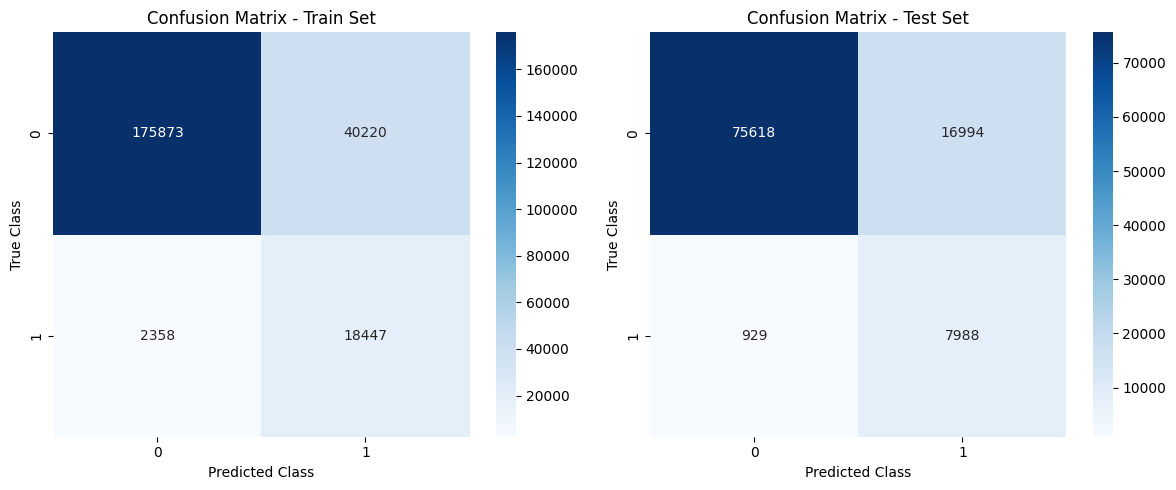

In [ ]:
plot_confusion_matrices(y_train, y_pred_train, y_test, y_pred_test)

The model correctly identified most low-credit clients (75,618 true negatives), but still produced 16,994 false positives, which are critical as they represent risky clients mistakenly considered creditworthy. On the other hand, only 929 false negatives occurred, meaning a smaller loss in terms of missed opportunities.
Overall, the model shows a good ability to recall high-risk clients, aligning with the business objective of minimizing financial risk.

ROC CURVE EVALUATION

In [ ]:
y_proba_train = lr.predict_proba(X_train)
y_proba_test = lr.predict_proba(X_test)

In [ ]:
def plot_roc_curves(y_train, y_proba_train, y_test, y_proba_test):
    # Calcolo per il training set
    fpr_train, tpr_train, _ = roc_curve(y_train, y_proba_train)
    auc_train = roc_auc_score(y_train, y_proba_train)

    # Calcolo per il test set
    fpr_test, tpr_test, _ = roc_curve(y_test, y_proba_test)
    auc_test = roc_auc_score(y_test, y_proba_test)

    # Plot affiancati
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # ROC Curve Train
    axes[0].plot(fpr_train, tpr_train, color='darkorange', lw=2, label=f'ROC Curve (AUC = {auc_train:.4f})')
    axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier (AUC = 0.5)')
    axes[0].set_xlim([0.0, 1.0])
    axes[0].set_ylim([0.0, 1.05])
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate (Recall)')
    axes[0].set_title('ROC Curve - Train Set')
    axes[0].legend(loc="lower right")
    axes[0].grid(True)

    # ROC Curve Test
    axes[1].plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'ROC Curve (AUC = {auc_test:.4f})')
    axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier (AUC = 0.5)')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate (Recall)')
    axes[1].set_title('ROC Curve - Test Set')
    axes[1].legend(loc="lower right")
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

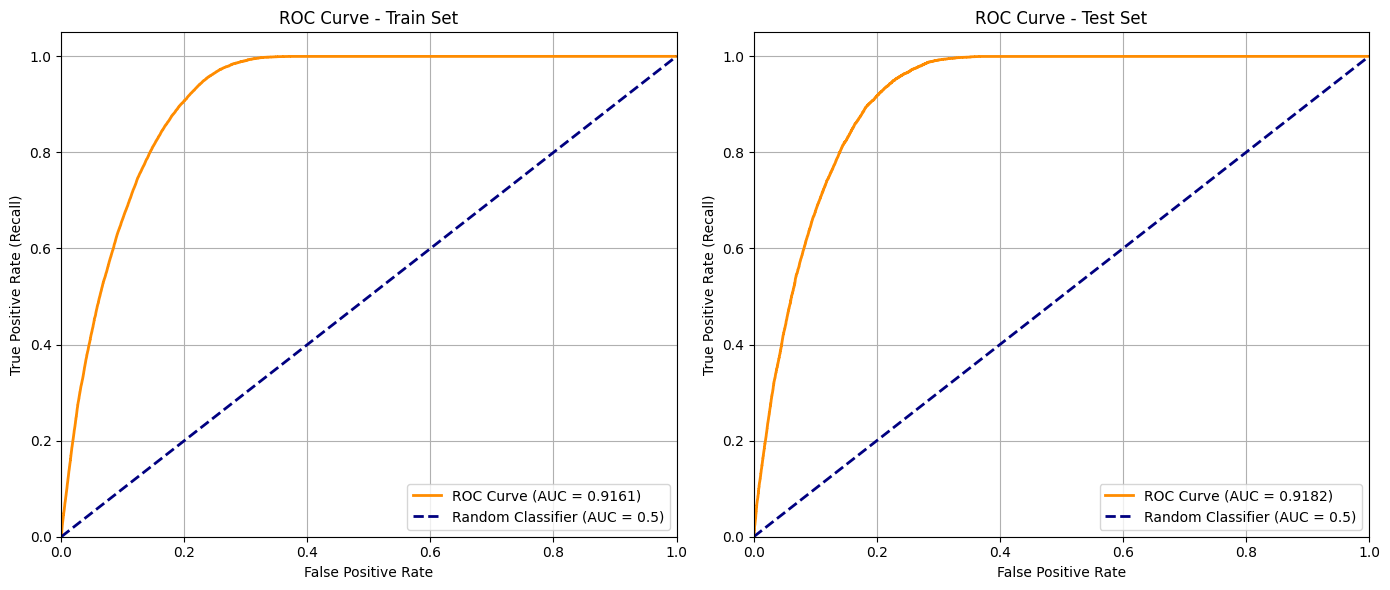

In [ ]:
plot_roc_curves(y_train, y_proba_train[:,1], y_test, y_proba_test[:,1])

The ROC curves show excellent discriminative ability:

AUC score is 0.9182 on the test set, indicating a high capability to distinguish between positive and negative classes.

The curve lies significantly above the diagonal (random classifier), reflecting strong model performance even under class imbalance.

THRESHOLD TUNING TO IMPROVE NEGATIVE CLASS RECALL

To better align the model with our business objective—minimizing false positives—we adjusted the classification threshold from the default 0.5 to 0.8. This shift encourages the model to be more conservative in predicting the positive class (high creditworthiness), thereby increasing the likelihood of correctly classifying clients with low creditworthiness (negative class).

In [ ]:
y_pred_train = np.where(y_proba_train[:,1]>0.8,1,0)
y_pred_test = np.where(y_proba_test[:,1]>0.8,1,0)

In [ ]:
print("TRAIN REPORT")
print(classification_report(y_train, y_pred_train))
print("TEST REPORT")
print(classification_report(y_test, y_pred_test))

TRAIN REPORT
              precision    recall  f1-score   support

           0       0.95      0.93      0.94    216093
           1       0.42      0.54      0.47     20805

    accuracy                           0.90    236898
   macro avg       0.69      0.73      0.71    236898
weighted avg       0.91      0.90      0.90    236898

TEST REPORT
              precision    recall  f1-score   support

           0       0.96      0.93      0.94     92612
           1       0.43      0.55      0.48      8917

    accuracy                           0.90    101529
   macro avg       0.69      0.74      0.71    101529
weighted avg       0.91      0.90      0.90    101529



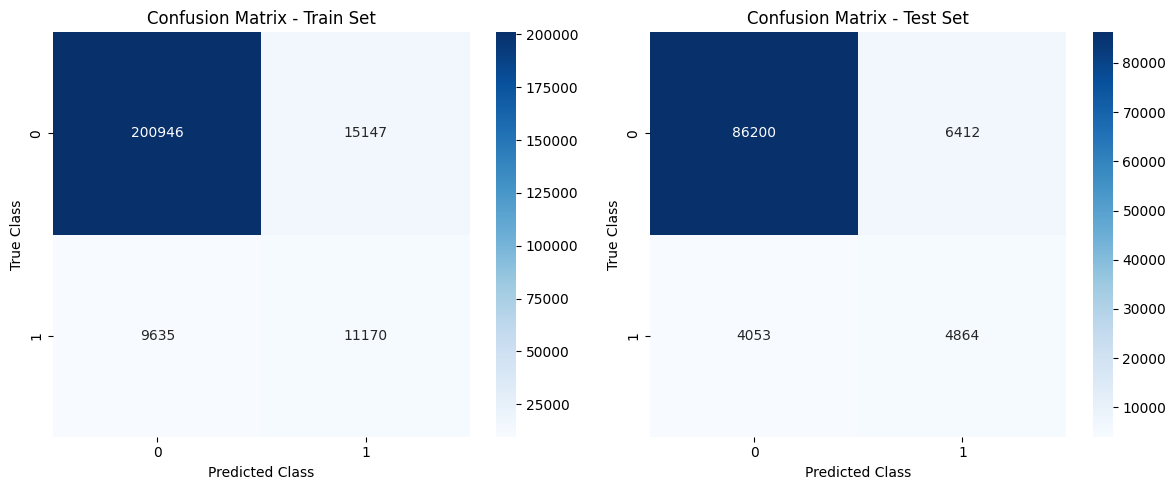

In [ ]:
plot_confusion_matrices(y_train, y_pred_train, y_test, y_pred_test)

After threshold adjustment, the recall for the negative class increased from 0.82 to 0.93 on the test set. This means the model now captures 93% of truly low-credit clients, significantly reducing the risk of misclassifying them as reliable. Although there's a slight trade-off in precision for the positive class, this shift is desirable for the business context, where failing to detect high-risk clients is more costly than wrongly rejecting a good one.

MODEL INTERPRETABILITY - LOGISTIC REGRESSION COEFFICIENTS

This step focuses on model interpretability, helping us identify which features have the strongest influence in driving the classification toward either the positive or negative class. Positive coefficients push the prediction toward the positive class (high credit reliability), while negative coefficients indicate a higher contribution toward the negative class (low credit reliability).

In [ ]:
feature_names = df.drop("TARGET", axis=1).columns

coefficients = lr.coef_[0]

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', ascending=False)

coef_df = coef_df.reset_index(drop=True)
print(coef_df)

                                              Feature  Coefficient
0                                    AMT_INCOME_TOTAL    52.757071
1                                   CNT_FAM_MEMBERS_3     0.139694
2                                  CNT_FAM_MEMBERS_>3     0.134951
3                                        FLAG_OWN_CAR     0.134020
4                            NAME_FAMILY_STATUS_Other     0.132423
5                                         CODE_GENDER     0.129313
6                           NAME_EDUCATION_TYPE_Other     0.122308
7                                          FLAG_EMAIL     0.117127
8                                          FLAG_PHONE     0.055522
9                               OCCUPATION_TYPE_Other     0.035984
10                                    FLAG_OWN_REALTY     0.021827
11  NAME_EDUCATION_TYPE_Secondary / secondary special     0.012028
12            NAME_FAMILY_STATUS_Single / not married     0.006768
13                                  CNT_FAM_MEMBERS_2    -0.03

The feature AMT_INCOME_TOTAL stands out with a significantly high positive coefficient, indicating it is the strongest contributor to the positive class (high credit reliability).

On the other hand, the most influential features for the negative class (low credit reliability) are:

DAYS_EMPLOYED

DAYS_BIRTH

OCCUPATION_TYPE_Pension

NAME_INCOME_TYPE_Pensioner

It is important to note that both DAYS_EMPLOYED and DAYS_BIRTH are represented as negative values, so an increase in their absolute value (i.e., a younger age or shorter employment history) increases the probability of being classified as low credit reliability.

OVER SAMPLING

In [ ]:
RANDOM_SEED = 0
X = df.drop("TARGET", axis=1).values
y = df["TARGET"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED, stratify=y)

print(f"Dimensione X_train: {X_train.shape}")
print(f"Dimensione X_test: {X_test.shape}")
print(f"Dimensione y_train: {y_train.shape}")
print(f"Dimensione y_test: {y_test.shape}")

Dimensione X_train: (236898, 26)
Dimensione X_test: (101529, 26)
Dimensione y_train: (236898,)
Dimensione y_test: (101529,)


In [ ]:
smote = SMOTE(random_state=0)

X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

In [ ]:
mms = MinMaxScaler()
X_train_over = mms.fit_transform(X_train_over)
X_test = mms.transform(X_test)

In [ ]:
lr = LogisticRegression()
lr.fit(X_train_over, y_train_over)

LogisticRegression()

In [ ]:
y_pred_train = lr.predict(X_train_over)
y_pred_test = lr.predict(X_test)

print("TRAIN REPORT")
print(classification_report(y_train_over, y_pred_train))
print("TEST REPORT")
print(classification_report(y_test, y_pred_test))

TRAIN REPORT
              precision    recall  f1-score   support

           0       0.88      0.82      0.85    216093
           1       0.83      0.89      0.86    216093

    accuracy                           0.85    432186
   macro avg       0.85      0.85      0.85    432186
weighted avg       0.85      0.85      0.85    432186

TEST REPORT
              precision    recall  f1-score   support

           0       0.99      0.82      0.89     92612
           1       0.32      0.89      0.47      8917

    accuracy                           0.82    101529
   macro avg       0.65      0.86      0.68    101529
weighted avg       0.93      0.82      0.86    101529



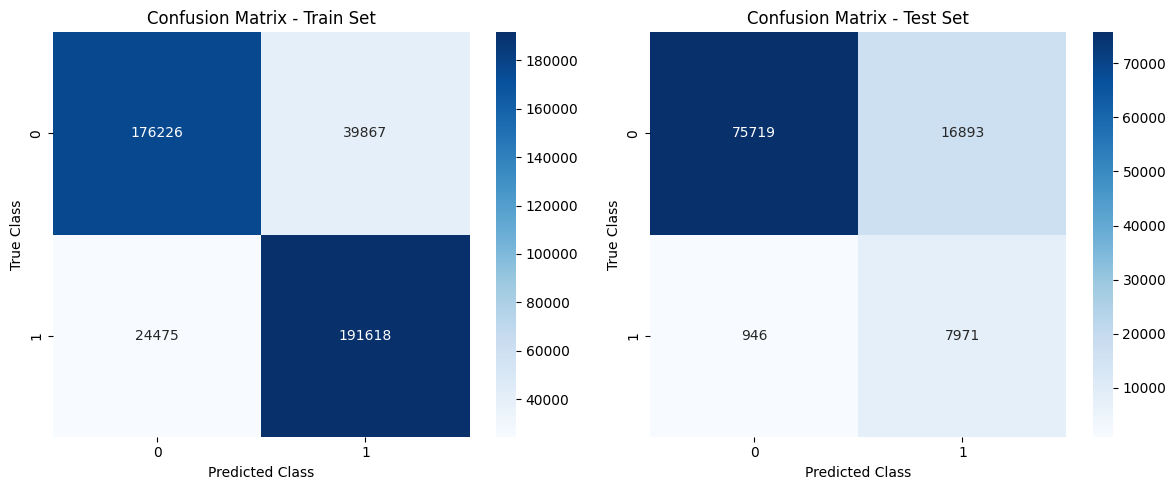

In [ ]:
plot_confusion_matrices(y_train_over, y_pred_train, y_test, y_pred_test)

In [ ]:
y_proba_train = lr.predict_proba(X_train_over)
y_proba_test = lr.predict_proba(X_test)

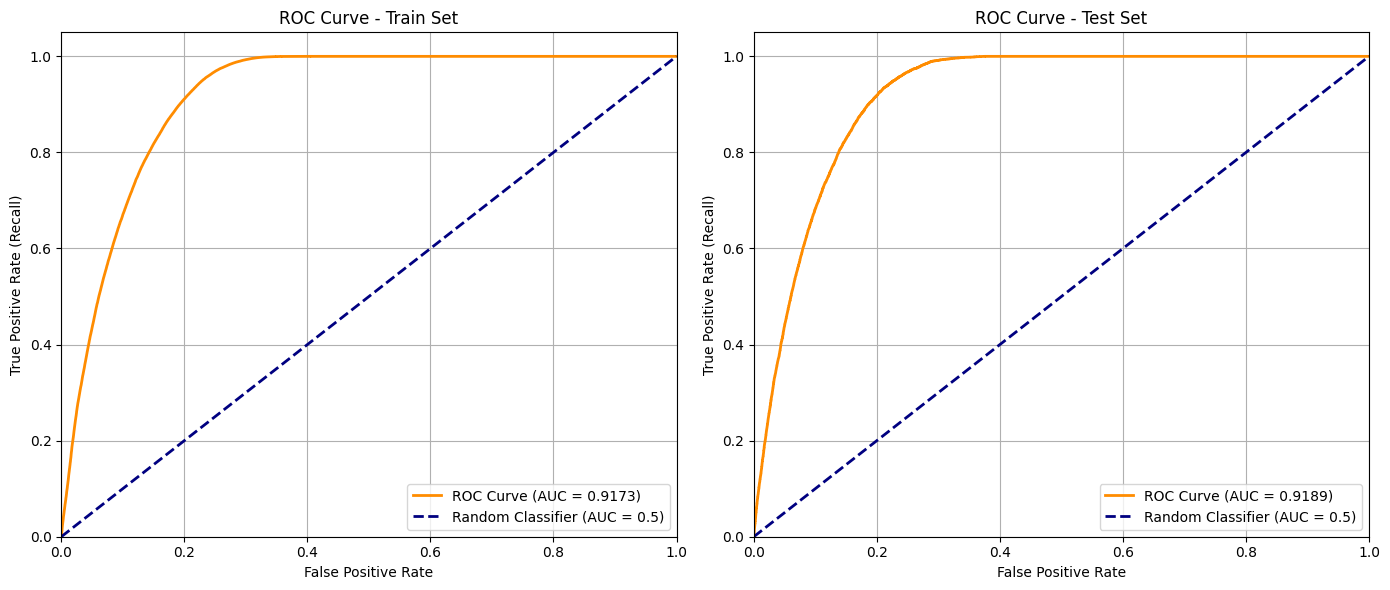

In [ ]:
plot_roc_curves(y_train_over, y_proba_train[:,1], y_test, y_proba_test[:,1])

Using SMOTE to oversample the minority class led to results similar to the model with class_weight='balanced', in terms of recall for the negative class (0.82 vs 0.82), accuracy (0.82 vs 0.82) and AUC (0.9189 vs 0.9182). However, it underperformed compared to the model with adjusted threshold (0.8), which achieved a recall of 0.93 and an overall accuracy of 0.90.

UNDER SAMPLING

In [ ]:
RANDOM_SEED = 0
X = df.drop("TARGET", axis=1).values
y = df["TARGET"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED, stratify=y)

print(f"Dimensione X_train: {X_train.shape}")
print(f"Dimensione X_test: {X_test.shape}")
print(f"Dimensione y_train: {y_train.shape}")
print(f"Dimensione y_test: {y_test.shape}")

Dimensione X_train: (236898, 26)
Dimensione X_test: (101529, 26)
Dimensione y_train: (236898,)
Dimensione y_test: (101529,)


In [ ]:
undersampler = RandomUnderSampler(random_state=42)

X_train_under, y_train_under = undersampler.fit_resample(X_train, y_train)

In [ ]:
mms = MinMaxScaler()
X_train_under = mms.fit_transform(X_train_under)
X_test = mms.transform(X_test)

In [ ]:
lr = LogisticRegression()
lr.fit(X_train_under, y_train_under)

LogisticRegression()

In [ ]:
y_pred_train = lr.predict(X_train_under)
y_pred_test = lr.predict(X_test)

print("TRAIN REPORT")
print(classification_report(y_train_under, y_pred_train))
print("TEST REPORT")
print(classification_report(y_test, y_pred_test))

TRAIN REPORT
              precision    recall  f1-score   support

           0       0.88      0.81      0.84     20805
           1       0.82      0.89      0.86     20805

    accuracy                           0.85     41610
   macro avg       0.85      0.85      0.85     41610
weighted avg       0.85      0.85      0.85     41610

TEST REPORT
              precision    recall  f1-score   support

           0       0.99      0.81      0.89     92612
           1       0.31      0.90      0.46      8917

    accuracy                           0.81    101529
   macro avg       0.65      0.85      0.67    101529
weighted avg       0.93      0.81      0.85    101529



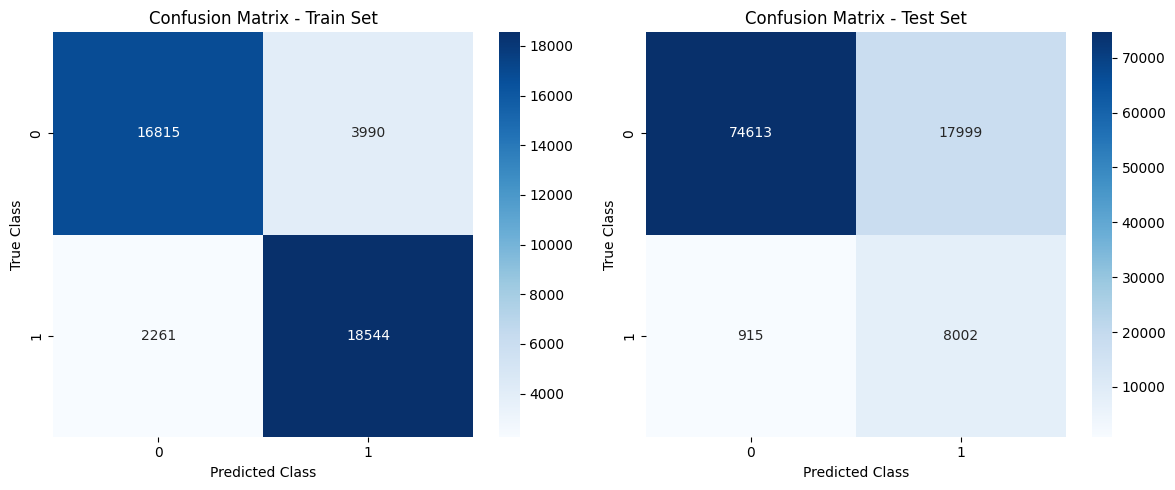

In [ ]:
plot_confusion_matrices(y_train_under, y_pred_train, y_test, y_pred_test)

In [ ]:
y_proba_train = lr.predict_proba(X_train_under)
y_proba_test = lr.predict_proba(X_test)

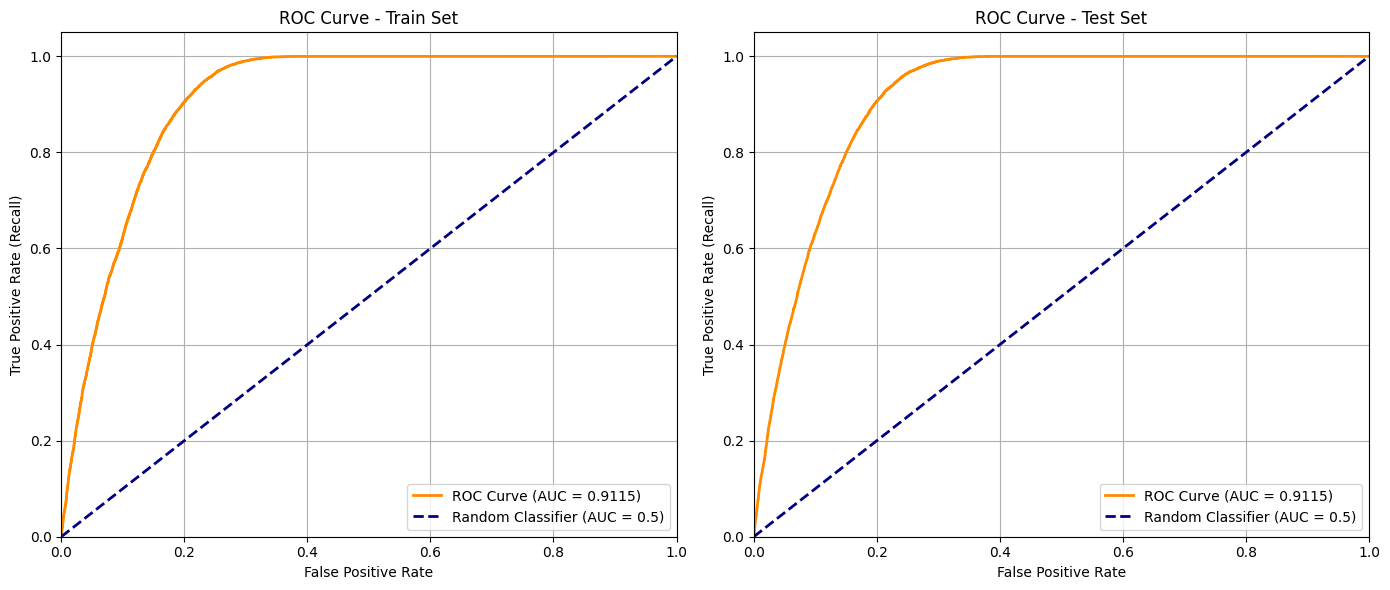

In [ ]:
plot_roc_curves(y_train_under, y_proba_train[:,1], y_test, y_proba_test[:,1])

Under sampling the majority class reduced overall performance, with slightly lower recall for the negative class (0.81 vs 0.82) and AUC (0.9115 vs 0.9182). This confirms it is less effective than using class weighting or threshold tuning in this scenario.

K-NEAREST NEIGHBORS (KNN)

In [ ]:
RANDOM_SEED = 0
X = df.drop("TARGET", axis=1).values
y = df["TARGET"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED, stratify=y)

print(f"Dimensione X_train: {X_train.shape}")
print(f"Dimensione X_test: {X_test.shape}")
print(f"Dimensione y_train: {y_train.shape}")
print(f"Dimensione y_test: {y_test.shape}")

Dimensione X_train: (236898, 26)
Dimensione X_test: (101529, 26)
Dimensione y_train: (236898,)
Dimensione y_test: (101529,)


In [ ]:
mms = MinMaxScaler()
X_train = mms.fit_transform(X_train)
X_test = mms.transform(X_test)

In [ ]:
kn = KNeighborsClassifier()
kn.fit(X_train, y_train)

KNeighborsClassifier()

In [ ]:
y_pred_train = kn.predict(X_train)
y_pred_test = kn.predict(X_test)

In [ ]:
print("TRAIN REPORT")
print(classification_report(y_train, y_pred_train))
print("TEST REPORT")
print(classification_report(y_test, y_pred_test))

TRAIN REPORT
              precision    recall  f1-score   support

           0       0.98      0.98      0.98    216093
           1       0.76      0.78      0.77     20805

    accuracy                           0.96    236898
   macro avg       0.87      0.88      0.87    236898
weighted avg       0.96      0.96      0.96    236898

TEST REPORT
              precision    recall  f1-score   support

           0       0.96      0.97      0.97     92612
           1       0.64      0.63      0.63      8917

    accuracy                           0.94    101529
   macro avg       0.80      0.80      0.80    101529
weighted avg       0.94      0.94      0.94    101529



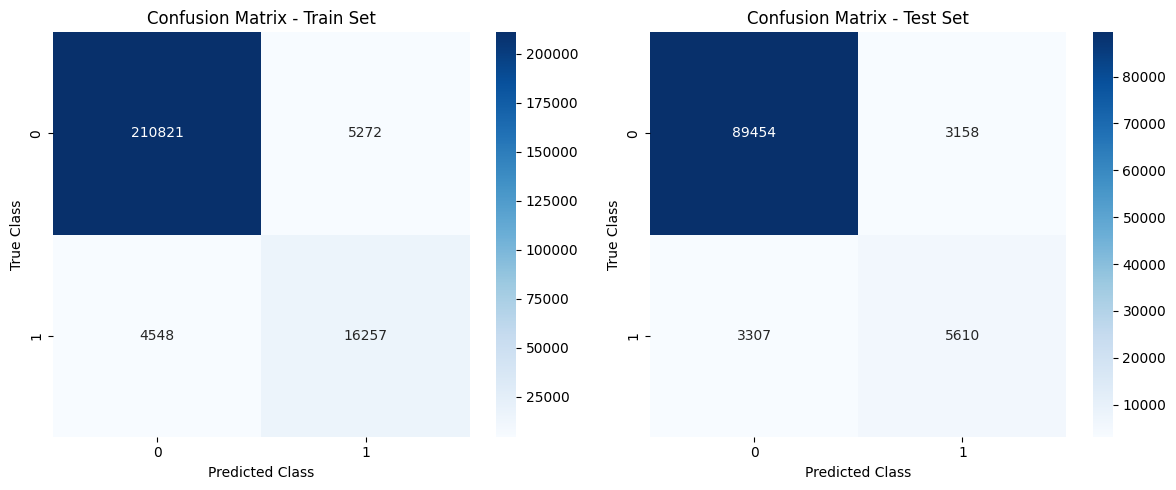

In [ ]:
plot_confusion_matrices(y_train, y_pred_train, y_test, y_pred_test)

Although KNN is not an interpretable model, we chose to apply it in order to compare its performance with other classifiers. The model shows strong results, particularly in terms of overall accuracy and the recall for the negative class. It successfully identifies the vast majority of true negatives, significantly reducing the number of false positives—3,158 on the test set compared to 6,412 achieved by the best-performing logistic regression model.

However, while KNN performs well, it comes with limitations. Unlike logistic regression, it lacks interpretability, which is crucial for understanding model decisions. Additionally, KNN is computationally more demanding at inference time, as it must compute the distance between each new observation and all points in the training set. This makes prediction slower and resource-intensive for large datasets.



DECISION TREE

In this section, a Decision Tree classifier was applied using a manually selected combination of hyperparameters, without performing grid search. The class imbalance was addressed using class_weight='balanced', which improves the model's ability to handle both majority and minority classes.

In [ ]:
RANDOM_SEED = 0
X = df.drop("TARGET", axis=1).values
y = df["TARGET"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED, stratify=y)

print(f"Dimensione X_train: {X_train.shape}")
print(f"Dimensione X_test: {X_test.shape}")
print(f"Dimensione y_train: {y_train.shape}")
print(f"Dimensione y_test: {y_test.shape}")

Dimensione X_train: (236898, 26)
Dimensione X_test: (101529, 26)
Dimensione y_train: (236898,)
Dimensione y_test: (101529,)


In [ ]:
tree = DecisionTreeClassifier(
    class_weight = "balanced",
    max_depth=8,
    min_samples_split=10,
    min_samples_leaf=3,
    max_features=9,
    max_leaf_nodes=45,
    random_state=0)

In [ ]:
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=8, max_features=9,
                       max_leaf_nodes=45, min_samples_leaf=3,
                       min_samples_split=10, random_state=0)

In [ ]:
y_pred_train = tree.predict(X_train)
y_pred_test = tree.predict(X_test)

print("TRAIN REPORT")
print(classification_report(y_train, y_pred_train))
print("TEST REPORT")
print(classification_report(y_test, y_pred_test))

TRAIN REPORT
              precision    recall  f1-score   support

           0       1.00      0.94      0.97    216093
           1       0.62      0.99      0.77     20805

    accuracy                           0.95    236898
   macro avg       0.81      0.97      0.87    236898
weighted avg       0.97      0.95      0.95    236898

TEST REPORT
              precision    recall  f1-score   support

           0       1.00      0.94      0.97     92612
           1       0.62      0.99      0.77      8917

    accuracy                           0.95    101529
   macro avg       0.81      0.97      0.87    101529
weighted avg       0.97      0.95      0.95    101529



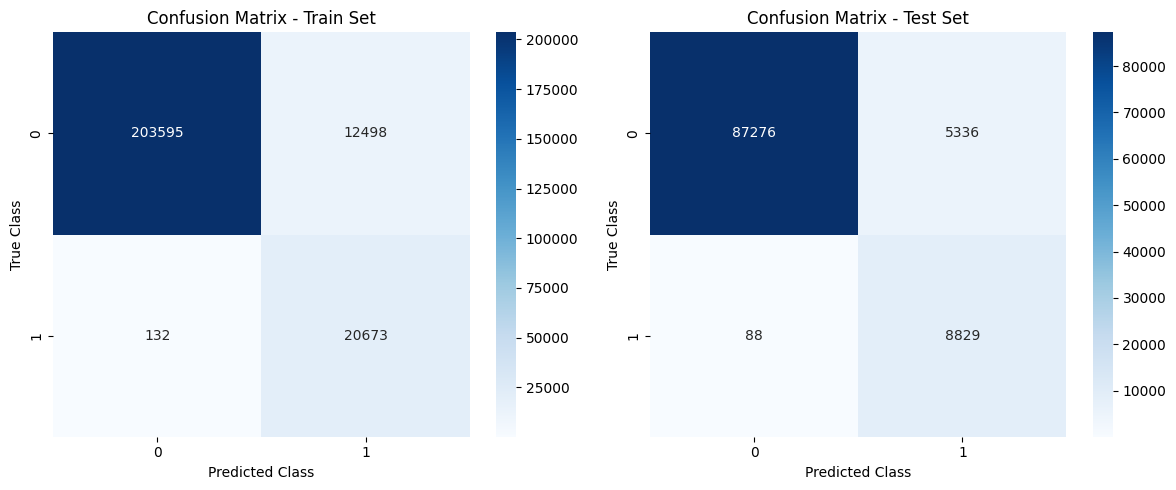

In [ ]:
plot_confusion_matrices(y_train, y_pred_train, y_test, y_pred_test)

The results show strong overall performance:

High accuracy on both training and test sets (95%)

Excellent recall for the negative class (94%)

No signs of overfitting, as performance is consistent across train and test sets

DECISION TREE VISUALIZATION – MODEL INTERPRETABILITY

To improve the interpretability of the decision tree model, we visualized the full decision structure using plot_tree. This allows us to understand how the model makes predictions by following the splits at each node based on specific feature thresholds.

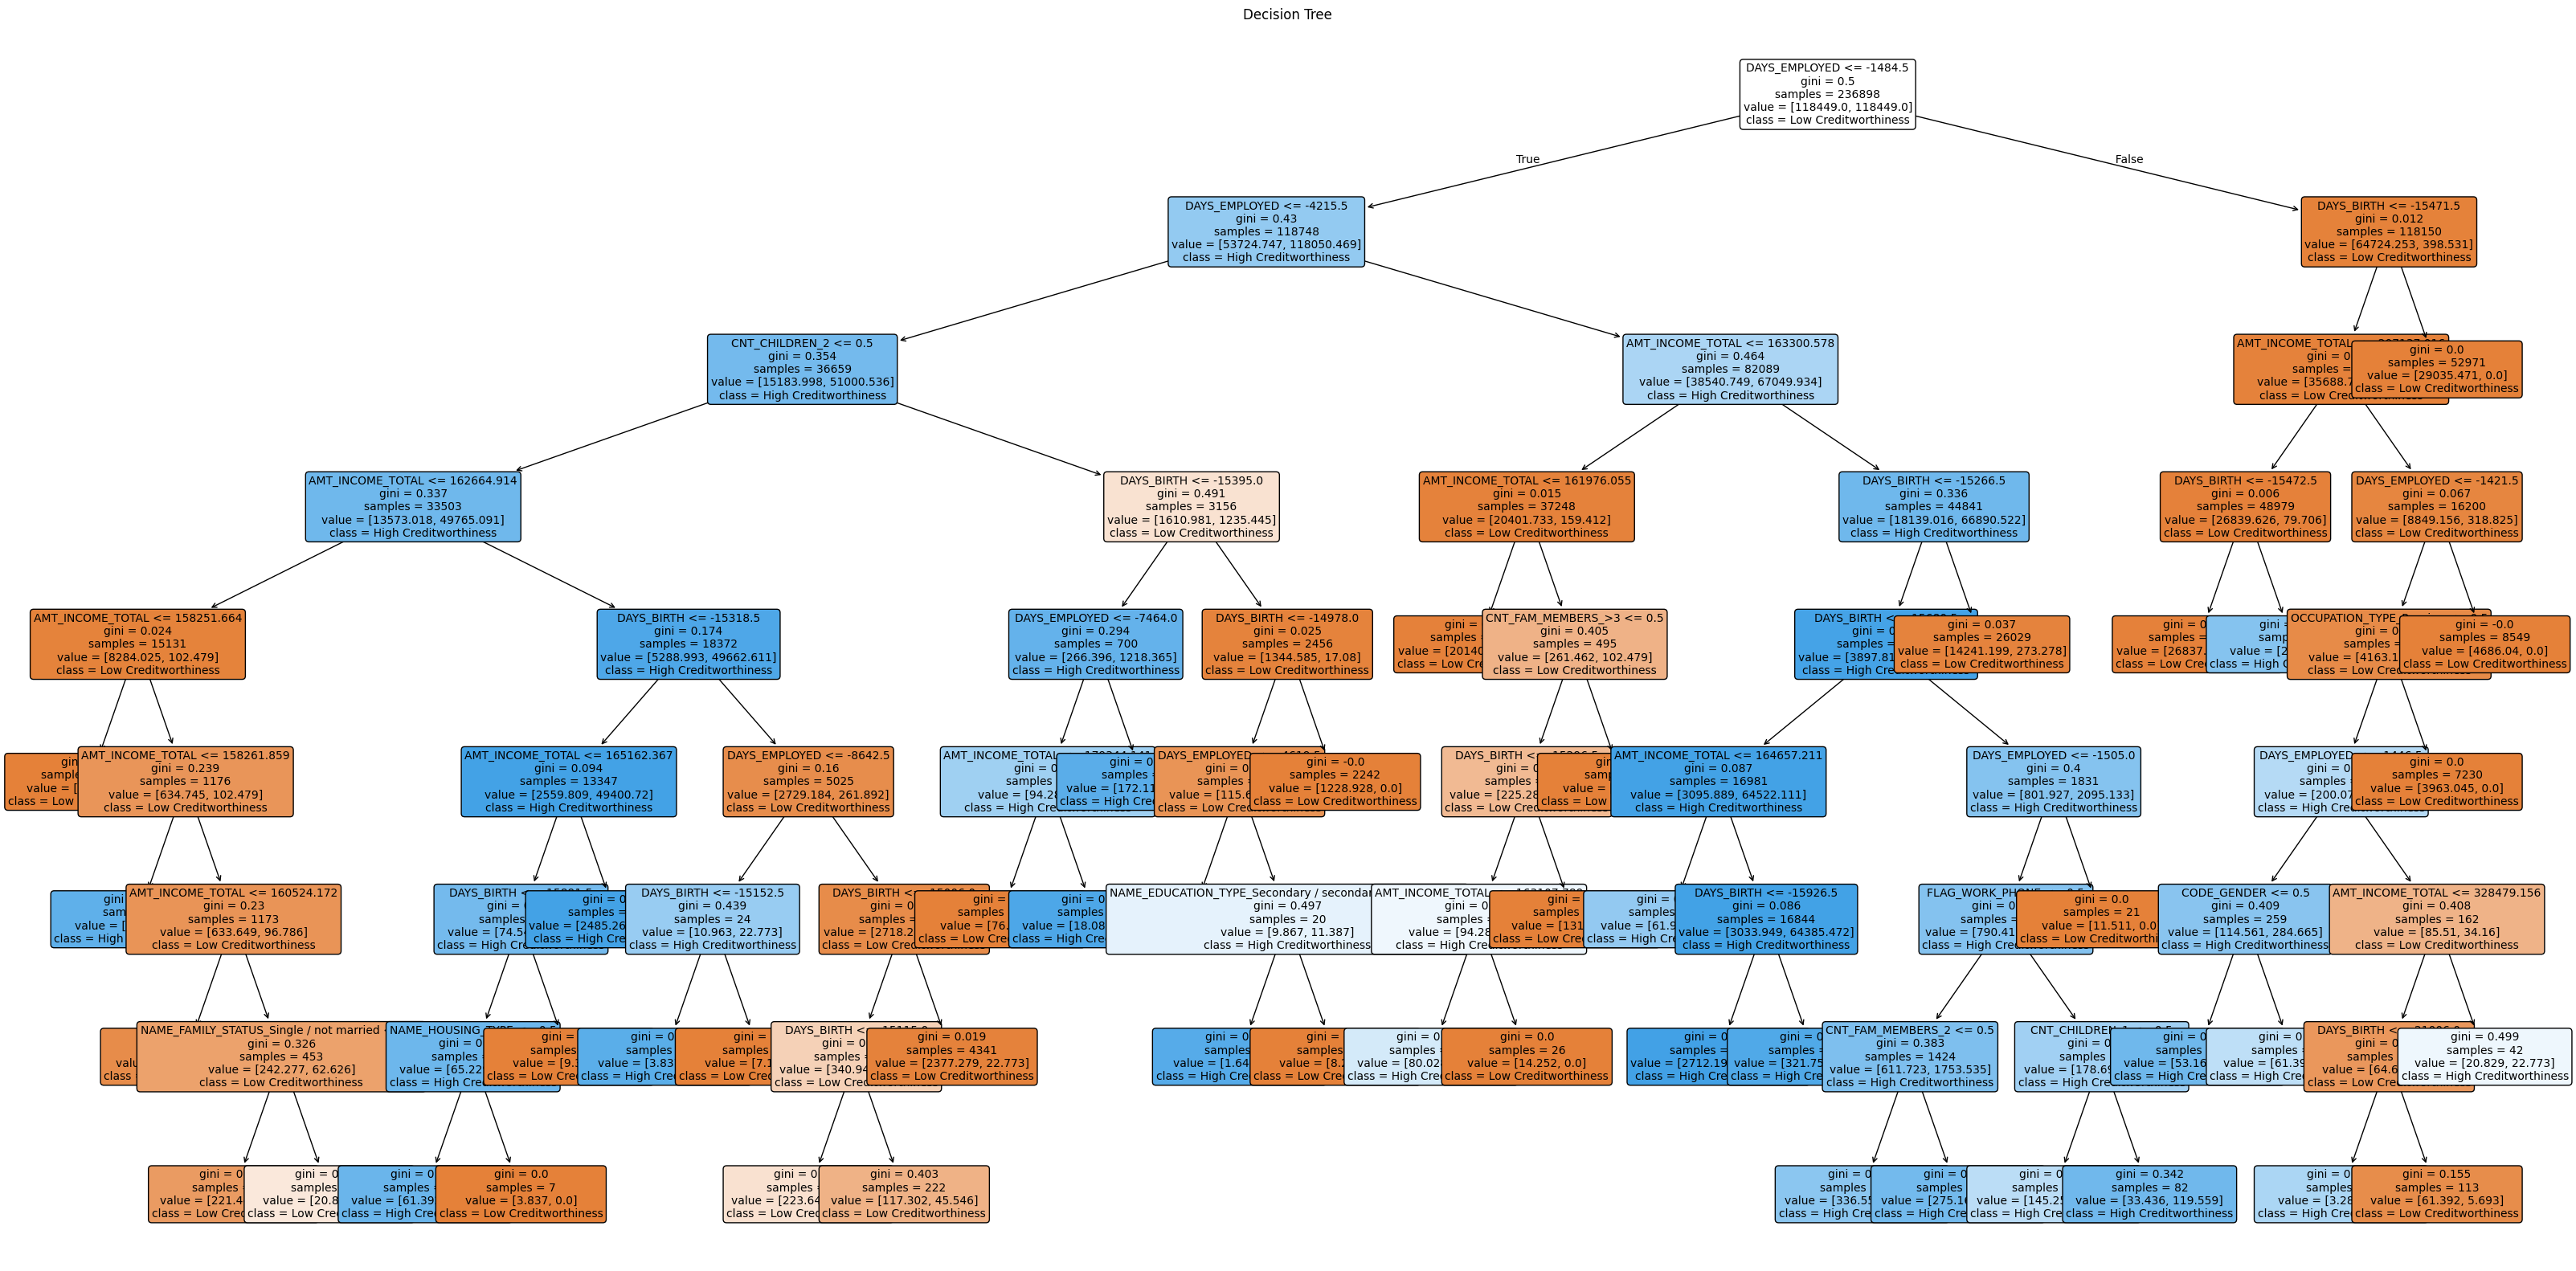

In [ ]:
feature_names = df.drop(['TARGET'], axis=1).columns

plt.figure(figsize=(40, 20))
plot_tree(tree,
          feature_names=feature_names,
          class_names=['Low Creditworthiness', 'High Creditworthiness'],
          filled=True,
          rounded=True,
          fontsize=10)
plt.title("Decision Tree")
plt.show()

FEATURE IMPORTANCE ANALYSIS

<ipython-input-196-48febb4c6686>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


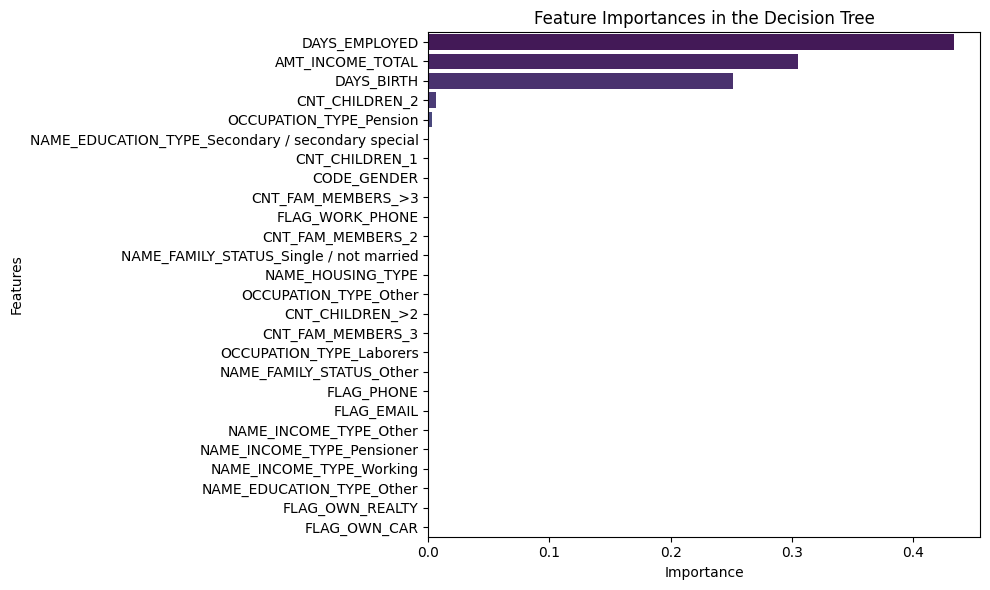

In [ ]:
importances = tree.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
sns.barplot(
    x=importances[indices],
    y=np.array(feature_names)[indices],
    palette="viridis"
)
plt.title("Feature Importances in the Decision Tree")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

To further assess model interpretability, we extracted and plotted feature importances using the feature_importances_ attribute of the decision tree. The resulting barplot ranks features based on their contribution to the classification process. The most influential features are:

DAYS_EMPLOYED

AMT_INCOME_TOTAL

DAYS_BIRTH

These three variables stand out with significantly higher importance scores than the others. Interestingly, they were also among the top features in the logistic regression model, which further confirms their relevance to the classification task across different algorithms.

RANDOM FOREST

In [ ]:
RANDOM_SEED = 0
X = df.drop("TARGET", axis=1).values
y = df["TARGET"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED, stratify=y)

print(f"Dimensione X_train: {X_train.shape}")
print(f"Dimensione X_test: {X_test.shape}")
print(f"Dimensione y_train: {y_train.shape}")
print(f"Dimensione y_test: {y_test.shape}")

Dimensione X_train: (236898, 26)
Dimensione X_test: (101529, 26)
Dimensione y_train: (236898,)
Dimensione y_test: (101529,)


In [ ]:
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features="sqrt",
    class_weight="balanced",
    n_jobs=-1,
    random_state=0
)

In [ ]:
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=5, min_samples_split=10, n_jobs=-1,
                       random_state=0)

In [ ]:
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

In [ ]:
print("TRAIN REPORT")
print(classification_report(y_train, y_pred_train))
print("TEST REPORT")
print(classification_report(y_test, y_pred_test))

TRAIN REPORT
              precision    recall  f1-score   support

           0       1.00      0.95      0.97    216093
           1       0.64      0.99      0.78     20805

    accuracy                           0.95    236898
   macro avg       0.82      0.97      0.87    236898
weighted avg       0.97      0.95      0.95    236898

TEST REPORT
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     92612
           1       0.64      0.99      0.78      8917

    accuracy                           0.95    101529
   macro avg       0.82      0.97      0.87    101529
weighted avg       0.97      0.95      0.95    101529



The model achieved very high performance both on the training and test sets. In particular, we observe:

Overall accuracy of 95% on both training and test sets.

Recall for the positive class (1) is extremely high (0.99), indicating the model is very effective at capturing true positives.

Precision for class 0 is perfect (1.00), suggesting very few false positives are generated.

Most importantly, the recall for class 0 reaches 0.95, meaning that 95% of true negatives are correctly identified. This is a critical aspect of our analysis, as minimizing false positives is a primary goal. A high recall for class 0 ensures that the model is highly reliable in identifying instances that do not belong to the positive class, significantly reducing the risk of overestimating positive predictions.

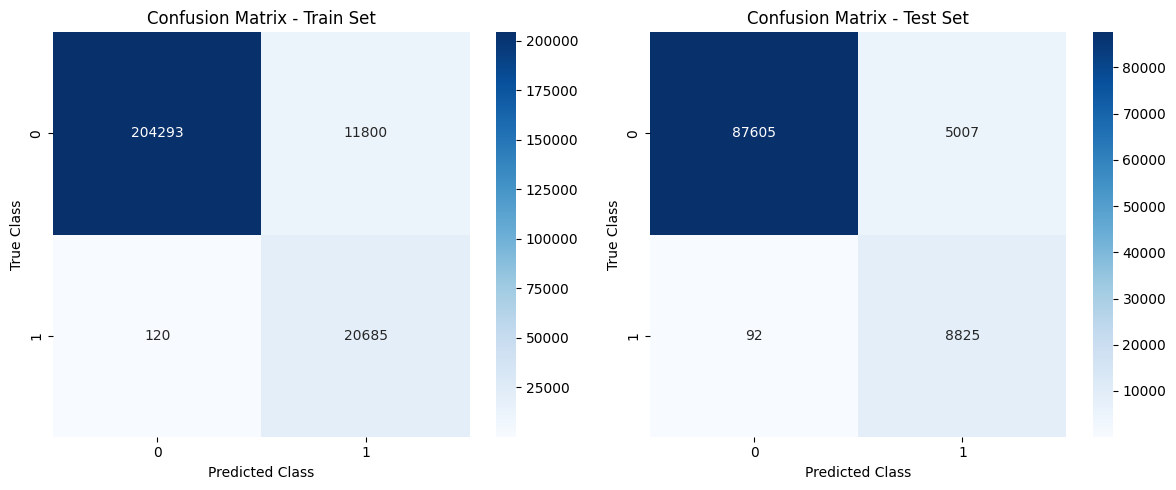

In [ ]:
plot_confusion_matrices(y_train, y_pred_train, y_test, y_pred_test)



Looking at the confusion matrix, the number of false positives on the test set (class 0 misclassified as 1) is only 5,007, which is lower than the value observed with logistic regression (6,412) and even better than decision tree (5,336), although slightly worse than KNN (3,158). The number of false negatives is very low (92), meaning that the model rarely fails to identify positive instances.

FEATURE IMPORTANCE ANALYSIS

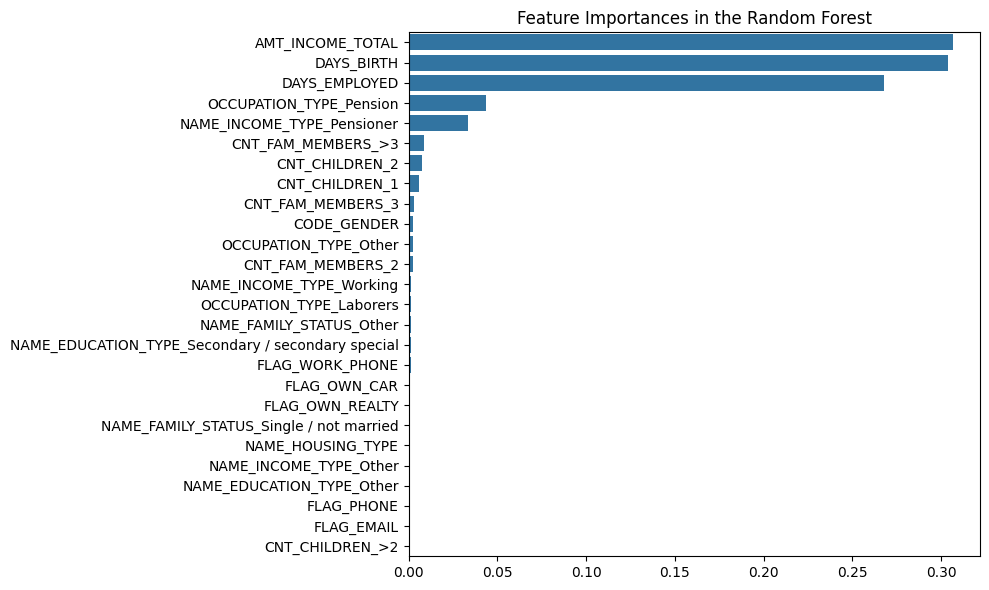

In [ ]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=np.array(feature_names)[indices])
plt.title("Feature Importances in the Random Forest")
plt.tight_layout()
plt.show()

The feature importance plot from the Random Forest model highlights AMT_INCOME_TOTAL, DAYS_BIRTH, and DAYS_EMPLOYED as the top three predictors for classification. These same features were also consistently ranked among the most influential in both the Decision Tree and Logistic Regression models, confirming their strong predictive power across different algorithms.

Additionally, OCCUPATION_TYPE_Pension and NAME_INCOME_TYPE_Pensioner appear as relevant features in the Random Forest, and were previously associated with strong negative coefficients in the Logistic Regression. This negative contribution favored the classification of the negative class, indicating a higher likelihood of default or lower creditworthiness.